In [76]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [77]:
df = pd.read_csv("cleaned_data/02-cleaned.csv")

In [78]:
df

,datetime,temp,dew,humidity,windspeed,winddir,sealevelpressure,precipitation
0,2016-07-01,21.1,68.9,96.8,9.2,78.4,1009.1,53.1000
1,2016-07-02,21.7,69.0,93.9,9.2,172.1,1009.8,13.7000
2,2016-07-03,23.2,69.8,88.4,12.8,216.1,1007.7,2.0000
3,2016-07-04,23.7,69.4,84.5,5.8,177.7,1006.3,16.8000
4,2016-07-05,24.3,69.9,82.7,11.4,110.0,1005.7,3.8000
...,...,...,...,...,...,...,...,...
3282,2025-06-26,24.8,71.6,85.9,11.4,220.1,1011.7,9.9000
3283,2025-06-27,24.8,71.1,84.0,12.8,237.0,1010.3,18.8000
3284,2025-06-28,24.5,70.5,84.3,11.4,278.3,1009.3,3.8000
3285,2025-06-29,23.1,71.4,94.2,16.1,223.2,1006.8,16.9672


In [79]:
df["datetime"] = pd.to_datetime(df["datetime"])


In [80]:
df.dtypes

datetime            datetime64[ns]
temp                       float64
dew                        float64
humidity                   float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
precipitation              float64
dtype: object

In [ ]:
def get_season(date):
    """
    Function to determine the season in Nepal based on the given date.
    Args:
        date (pd.Timestamp): A datetime object.
    Returns:
        str: The season corresponding to the date.
    """
    month = date.month
    day = date.day

    # Spring: Mid-March to Mid-May (blooming season, pre-monsoon)
    if (month == 3 and day >= 15) or (month == 4) or (month == 5 and day <= 15):
        return "Spring"  # 2 months 
    
    # Summer/Monsoon: 
    # - Early Summer (pre-monsoon heat): Mid-May to Mid-June
    # - Peak Monsoon: Mid-June to Mid-September
    elif (month == 5 and day > 15) or (month == 6 and day <= 15):
        return "Summer(Pre-Monsoon)" # 1 month
    elif (month == 6 and day > 15) or (month == 7) or (month == 8) or (month == 9 and day <= 15):
        return "Monsoon" # 3 months
    
    # Autumn: Mid-September to Mid-November (post-monsoon, harvest season)
    elif (month == 9 and day > 15) or (month == 10) or (month == 11 and day <= 15):
        return "Autumn" # 2 months
    
    # Winter: Mid-November to Mid-March (cold, dry season)
    else: # ( month == 11 and day > 15 ) or ( month == 12 ) or ( month == 1 ) or ( month == 2 )or ( month == 3 and day <15 )
        return "Winter" # 4 months

In [82]:
df["month"] = df["datetime"].dt.month
df['season'] = df['datetime'].apply(get_season)


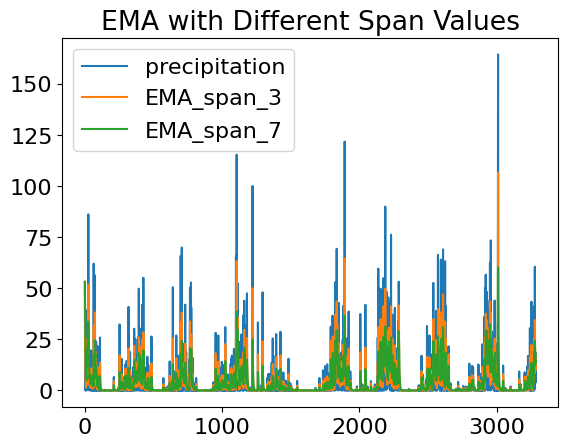

<Figure size 5000x2500 with 0 Axes>

In [83]:
spans = [3,7]
for span in spans:
    df[f'EMA_span_{span}'] = df['precipitation'].ewm(span=span, adjust=False).mean()

df[['precipitation'] + [f'EMA_span_{span}' for span in spans]].plot()

plt.title('EMA with Different Span Values')
plt.figure(figsize=(50,25))

plt.show()

#deleting
for span in spans:
    df = df.drop(columns=[f"EMA_span_{span}"])

In [84]:
#rolling averages introduce lag, particularly when using simple movingaverages (SMA) with fixed window sizes
# so we use  exponential moving averages (EMA), which assign higher weights to more recent observations

#A smaller span gives more weight to recent observations, making the EMA more responsive to changes but also more volatile.
#A larger span smooths out fluctuations, giving equal importance to a broader range of past observations.

span = 3
df["temp_EMA_3_days"] = df['temp'].ewm(span=span, adjust=False).mean()


### Constructing Lagged Variables for Temperature and Humidity

In [85]:

df['humidity_lag_3_days'] = df['humidity'].shift(3)
# df['precipitation_lag_2_days']=df['precipitation'].shift(2)
# df = df.drop(columns=['precipitation_lag_2_days'])

In [86]:
df.dtypes

datetime               datetime64[ns]
temp                          float64
dew                           float64
humidity                      float64
windspeed                     float64
winddir                       float64
sealevelpressure              float64
precipitation                 float64
month                           int32
season                         object
temp_EMA_3_days               float64
humidity_lag_3_days           float64
dtype: object

In [87]:
df.isna().sum()

datetime               0
temp                   0
dew                    0
humidity               0
windspeed              0
winddir                0
sealevelpressure       0
precipitation          0
month                  0
season                 0
temp_EMA_3_days        0
humidity_lag_3_days    3
dtype: int64

In [88]:
# adjusting the null values in the newly created features

df.humidity_lag_3_days = df.humidity_lag_3_days.fillna(df.humidity_lag_3_days.iloc[3:11].mean()) #applying 1 week avg


In [89]:
#  approach captures the cyclical nature of months while reducing dimensionality compared to one-hot encoding 
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [90]:
df.head()

,datetime,temp,dew,humidity,windspeed,winddir,sealevelpressure,precipitation,month,season,temp_EMA_3_days,humidity_lag_3_days,month_sin,month_cos
0,2016-07-01,21.1,68.9,96.8,9.2,78.4,1009.1,53.1,7,Monsoon,21.10,87.425,-0.5,-0.866025
1,2016-07-02,21.7,69.0,93.9,9.2,172.1,1009.8,13.7,7,Monsoon,21.40,87.425,-0.5,-0.866025
2,2016-07-03,23.2,69.8,88.4,12.8,216.1,1007.7,2.0,7,Monsoon,22.30,87.425,-0.5,-0.866025
3,2016-07-04,23.7,69.4,84.5,5.8,177.7,1006.3,16.8,7,Monsoon,23.00,96.800,-0.5,-0.866025
4,2016-07-05,24.3,69.9,82.7,11.4,110.0,1005.7,3.8,7,Monsoon,23.65,93.900,-0.5,-0.866025


In [91]:
seasons_dict = {'Spring': 1, 
                'Summer(Pre-Monsoon)': 2, 
                'Monsoon': 3, 
                'Autumn': 4, 
                'Winter': 5
                }

In [92]:
# mapping seasons to it's numbers by creating a new column
df["season_number"] = df["season"].map(seasons_dict)

In [93]:
total_seasons = len(seasons_dict.items())
total_seasons

5

In [94]:
# implementing cyclic encoding on the season

df["season_sin"] = np.sin(2 * np.pi * df['season_number'] / total_seasons)
df["season_cos"] = np.cos(2 * np.pi * df['season_number'] / total_seasons)

In [95]:
# df.to_csv("test.csv",index=False)

In [96]:
# Integrates temperature and humidity to measure perceived heat.
# Provides actionable insights for extreme weather conditions.
# df["heat index"] = df.temp - ((100 - df.humidity)/5)

# df["wind chill"] = df.temp * df.windspeed


In [97]:
# Vapor Pressure Deficit (VPD)
# Derived from temperature and humidity, crucial for predicting drought stress and fire risks.
# VPD significantly influences vegetation productivity and wildfire risks.

# def VPD(row):
#     # Calculate saturation vapor pressure (e_s)
#     e_s = 6.1708 * np.exp((17.2 * row["temp"]) / (row["temp"] + 237.3))
    
#     # Calculate actual vapor pressure (e_a)
#     e_a = round(row["temp"] * row["humidity"] / 100, 1)
    
#     # Return the vapor pressure deficit (VPD)
#     return e_s - e_a

# df["Vapor Pressure Deficit"] = df.apply(VPD, axis=1)


In [98]:
# Helps understand atmospheric aridity and its impact on precipitation.
# df["dew_point_depression"]=df.temp - df.dew 

In [99]:
# Seasonal Wind Direction Patterns

# Encodes wind direction with sine/cosine transformations to capture seasonal variations.
# Enhances the ability to model cyclical trends in precipitation data.

df['winddir_sin'] = np.sin(np.radians(df['winddir']))
df['winddir_cos'] = np.cos(np.radians(df['winddir']))

# Combining these with seasonal encodings (season_sin, season_cos)
df['combined_seasonal_wind_pattern'] = np.sqrt(
    df['winddir_sin']**2 + df['winddir_cos']**2 + df['season_sin']**2 + df['season_cos']**2
)

In [100]:
# Temperature-Humidity Interaction (Cross-Lagged)
# Cross-lagged interactions between temperature and humidity changes over time.
#  Capturing lagged effects improves understanding of complex environmental interactions.
df['temp_humidity_interaction'] = (
    (df['temp'] - df['temp_EMA_3_days']) *
    (df['humidity'] - df['humidity_lag_3_days'])
)

In [101]:
# Wind-driven moisture flux:
df['moisture_flux'] = df['windspeed'] * np.sin(np.radians(df['winddir'])) * df['humidity']


#### Rainfall-related features tailored to Kathmandu's geography

In [102]:
# """ Orographic Precipitation Potential
# #Estimates the likelihood of orographic rainfall caused by moist air rising over hills.
# #Hills surrounding Kathmandu force moist air to rise, cool, and condense, leading to enhanced rainfall on windward slopes and rain shadows on leeward slopes.
# """
# df['orographic_precipitation_potential'] = df['windspeed'] * np.sin(np.radians(df['winddir'])) * df['humidity']

#Positive values indicate windward slopes (enhanced rainfall).
#Negative values indicate leeward slopes (rain shadow).

In [103]:
"""
Valley Temperature Inversion Index
#Captures temperature inversion events where cooler air gets trapped in the valley.
# Temperature inversions are common in valleys like Kathmandu, especially during winter nights, and can suppress rainfall.
"""
# Placeholder for elevation difference (e.g., 500 meters)
delta_z = 500
df['temperature_inversion_index'] = (df['temp'] - df['dew']) / delta_z

In [104]:
"""
Wind Channeling Effect
#  Measures how wind speed and direction interact with the valley's topography.
#  Winds are often channeled through valleys, affecting local precipitation patterns.
"""
df['wind_channeling_effect'] = df['windspeed'] * np.cos(np.radians(df['winddir']))

In [105]:
"""
Rain Shadow Effect
# Quantifies the reduction in precipitation due to rain shadowing on the leeward side of hills.
# Kathmandu lies in a rain shadow during certain wind directions, reducing rainfall.
"""
#Negative sine values indicate leeward slopes.
df['wind_shadow_effect'] = np.maximum(0, -np.sin(np.radians(df['winddir']))) * df['windspeed']

In [106]:
# """
#  Urban Heat Island Effect on Rainfall
# Description : Captures how urbanization in Kathmandu modifies local rainfall patterns.
# Justification : Urban heat islands can enhance convection and localized rainfall.
# """
# df['urban_heat_island_effect'] = df['temp'] - df['dew'] + (df['sealevelpressure'] / 1000)

In [107]:
""" 
Convective Rainfall Potential
Description : Estimates the potential for convective rainfall driven by localized heating in the valley.
Justification : Convective storms are common in Kathmandu during pre-monsoon and monsoon seasons.
"""
df['convective_rainfall_potential'] = ((df['temp'] - df['dew']) * df['windspeed']) / df['humidity']

In [108]:
# df.to_csv("test.csv",index=False)

In [109]:
# """   
# Convective Precipitation Potential
# Description : Estimates the likelihood of convective rainfall based on temperature and humidity gradients.
# Justification : Convection-driven rainfall is common in thunderstorms.
# """
# df['convective_precipitation_potential'] = ((df['temp'] - df['dew']) * df['windspeed']) / df['sealevelpressure']

In [110]:

len(df.dtypes)

26

In [111]:
df.isna().sum()

datetime                          0
temp                              0
dew                               0
humidity                          0
windspeed                         0
winddir                           0
sealevelpressure                  0
precipitation                     0
month                             0
season                            0
temp_EMA_3_days                   0
humidity_lag_3_days               0
month_sin                         0
month_cos                         0
season_number                     0
season_sin                        0
season_cos                        0
winddir_sin                       0
winddir_cos                       0
combined_seasonal_wind_pattern    0
temp_humidity_interaction         0
moisture_flux                     0
temperature_inversion_index       0
wind_channeling_effect            0
wind_shadow_effect                0
convective_rainfall_potential     0
dtype: int64

In [112]:
df.duplicated().sum()

0

In [113]:
df.to_csv("cleaned_data/03-interaction_features.csv",index=False)

# now visualizing and interpreting the relations between target and other features

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [59]:
#chnge the path to -> /home/momo/Downloads/dataset for prec/cleaned_data/03-interaction_features.csv
df  = pd.read_csv("/home/momo/Downloads/dataset for prec/cleaned_data/03-interaction_features.csv")

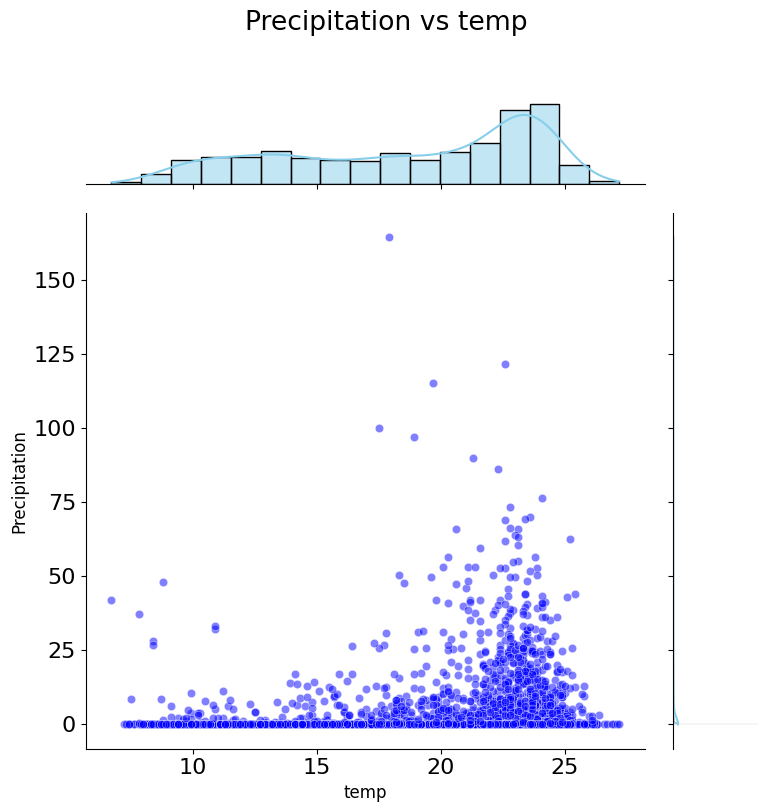

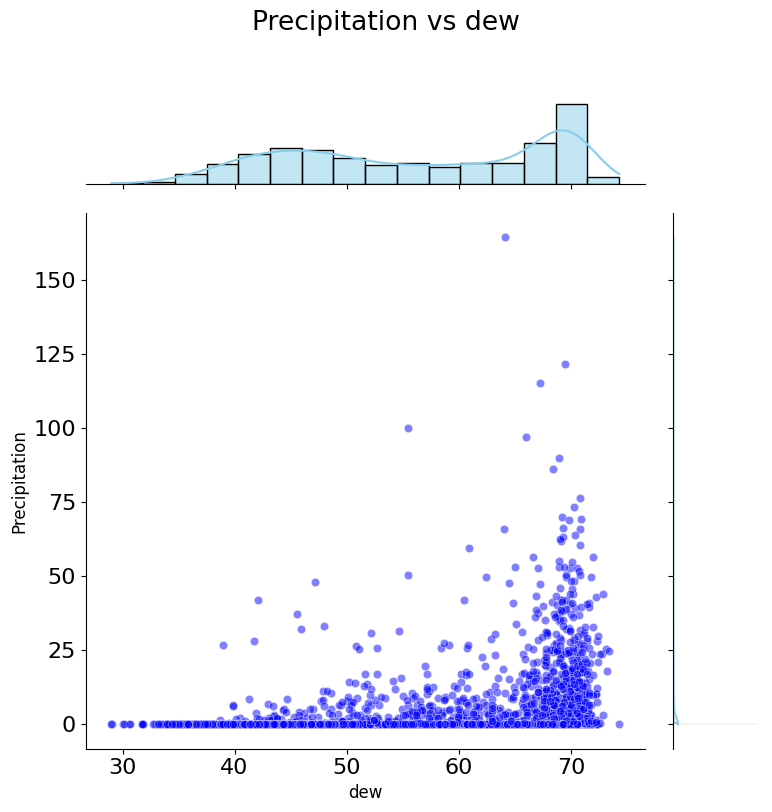

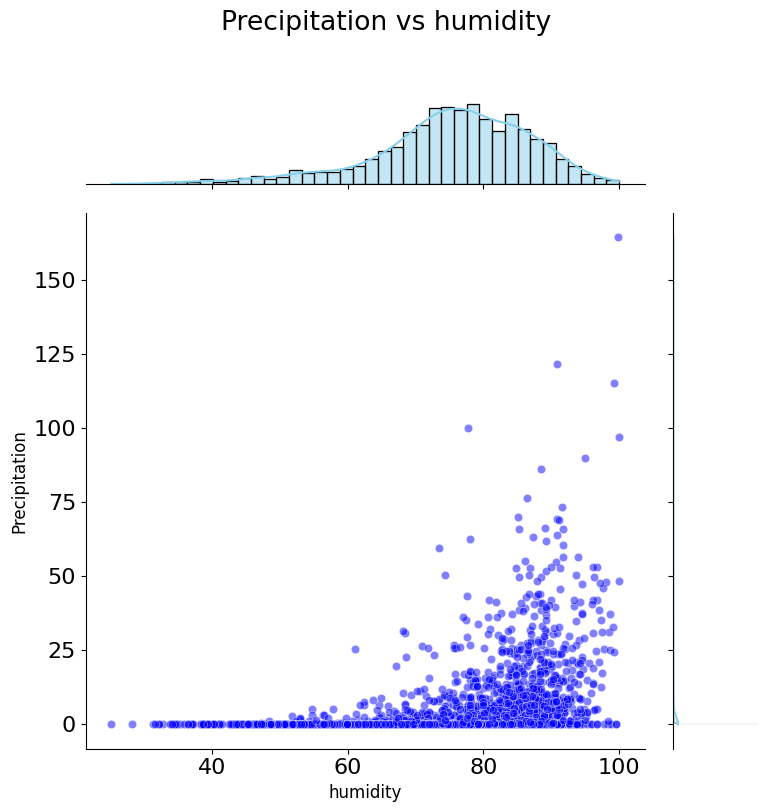

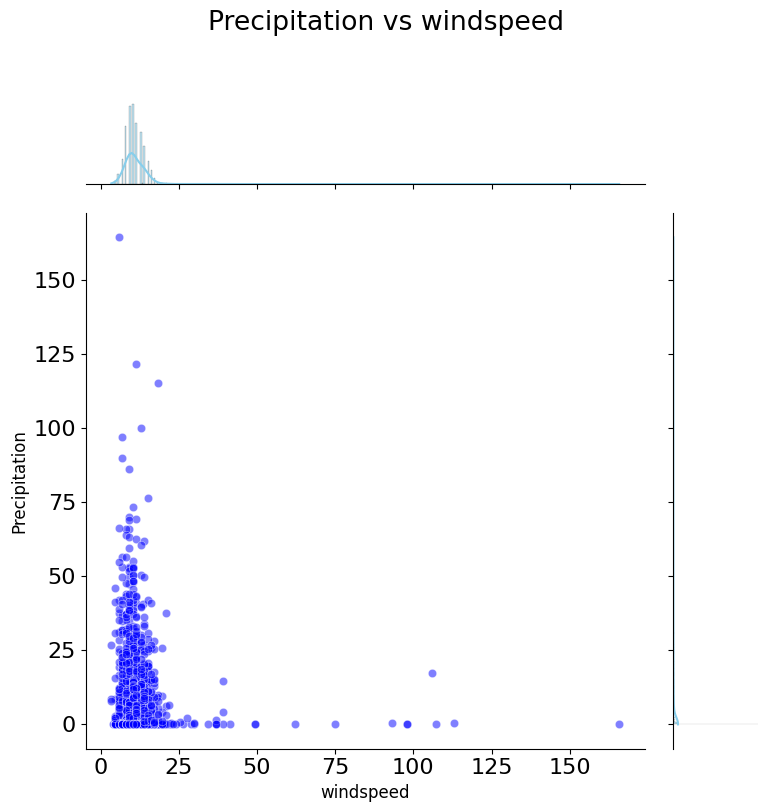

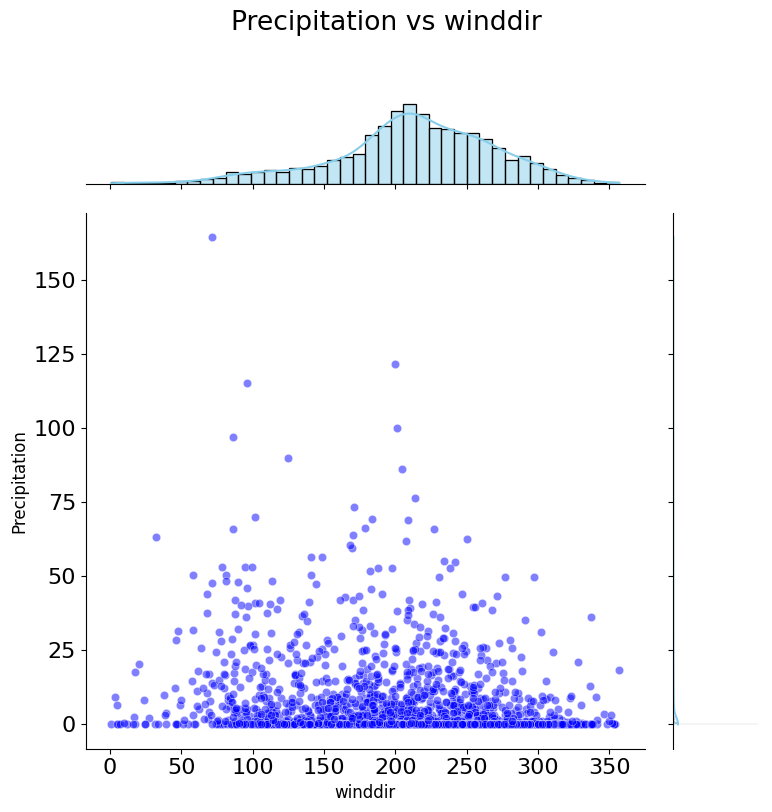

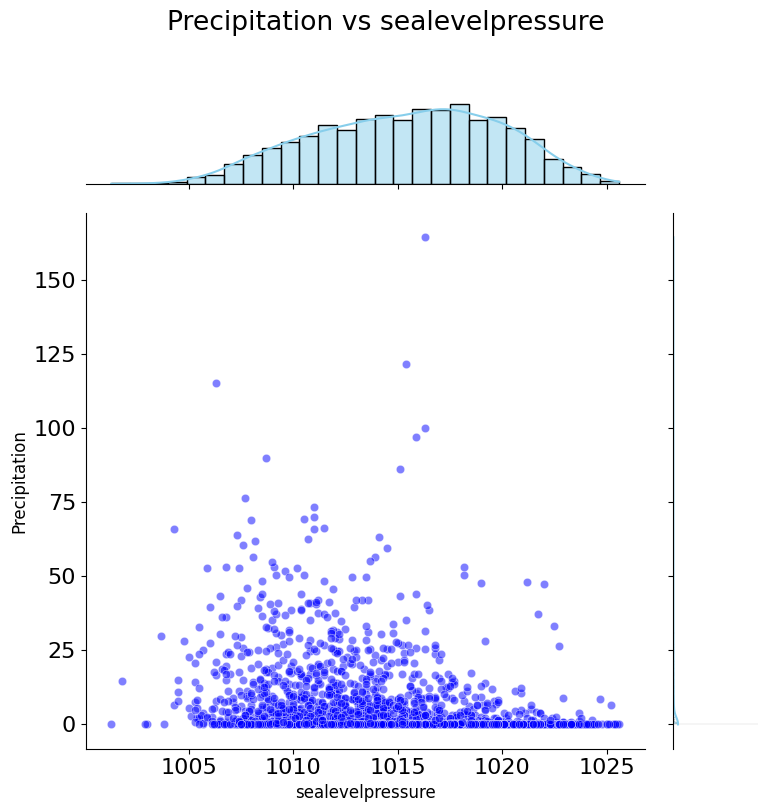

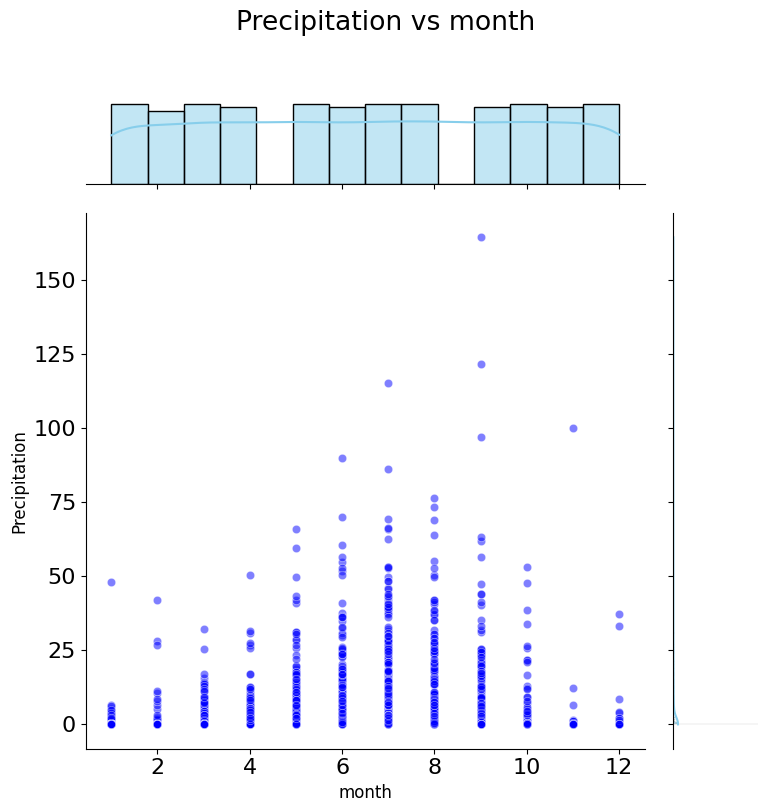

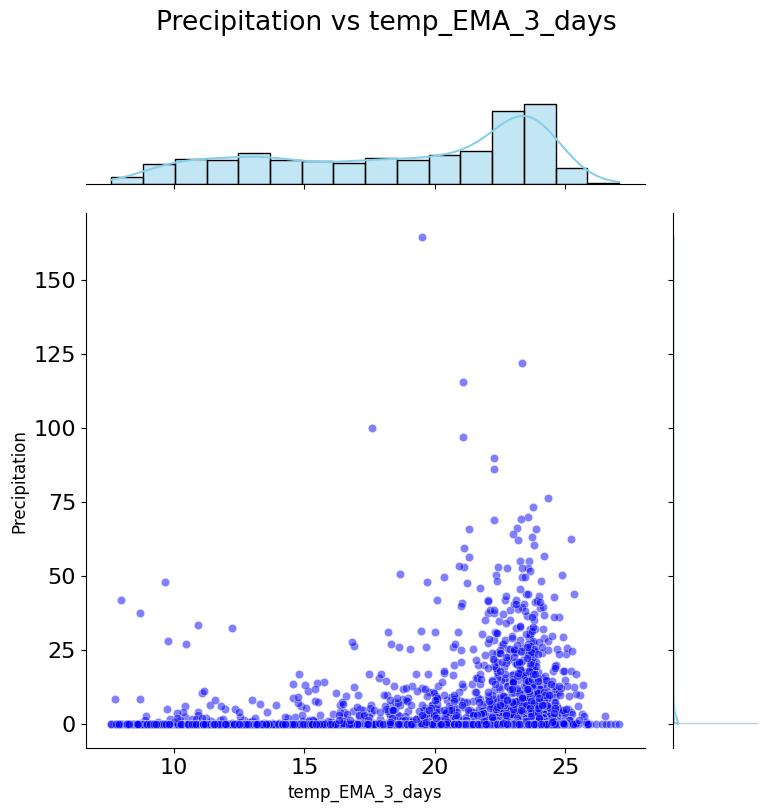

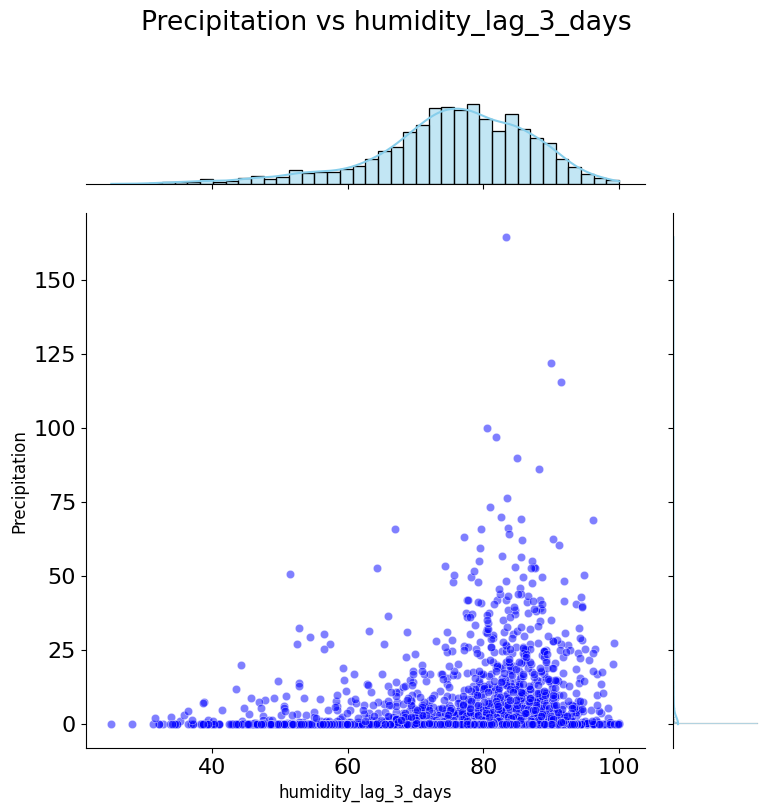

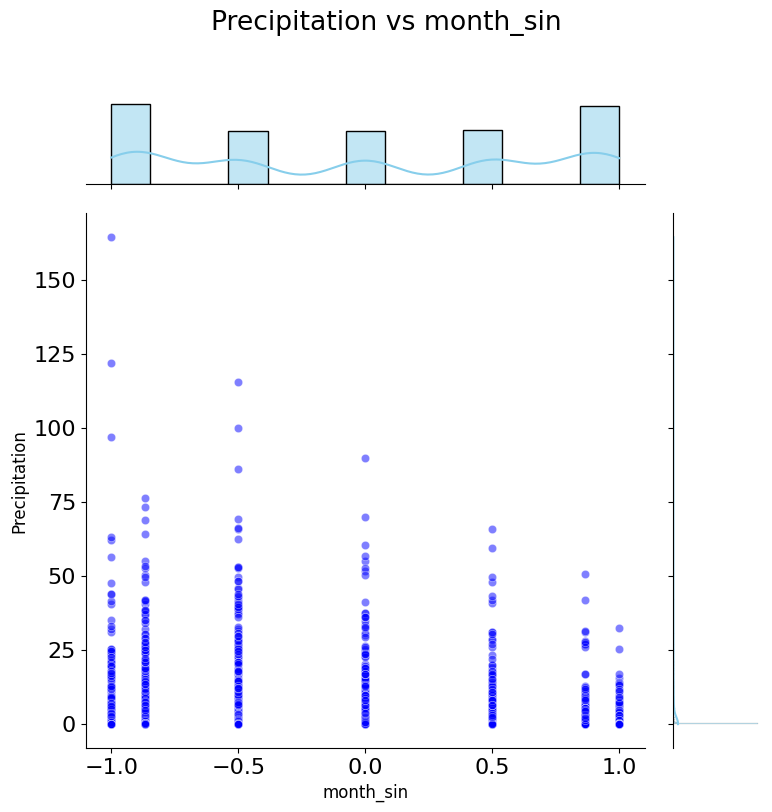

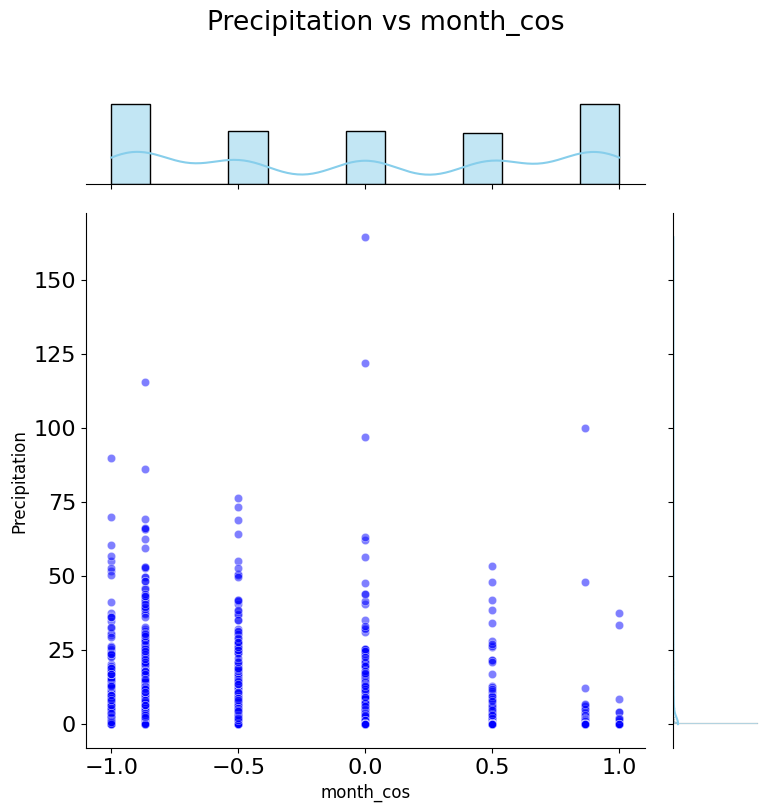

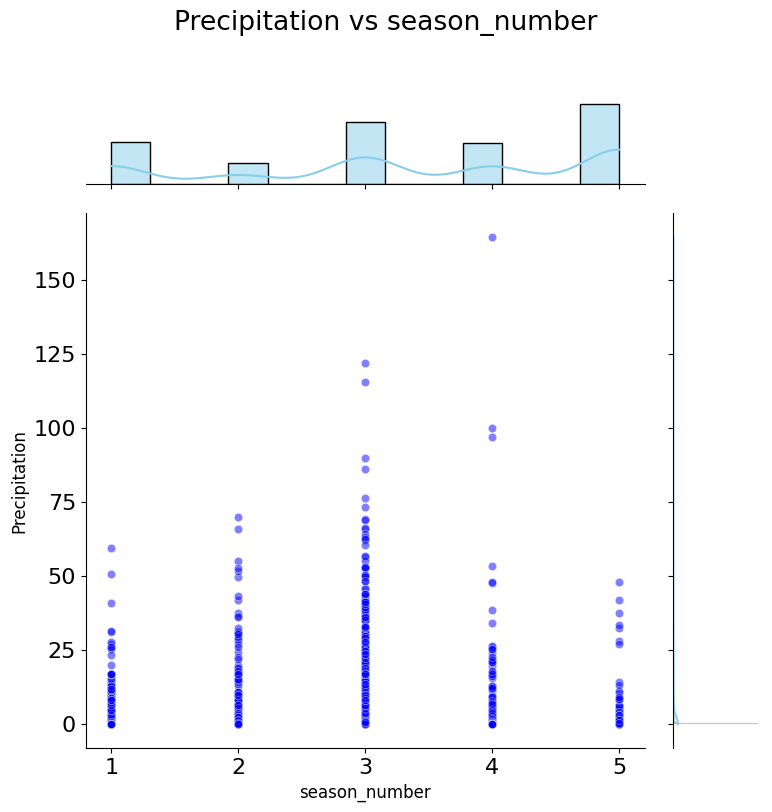

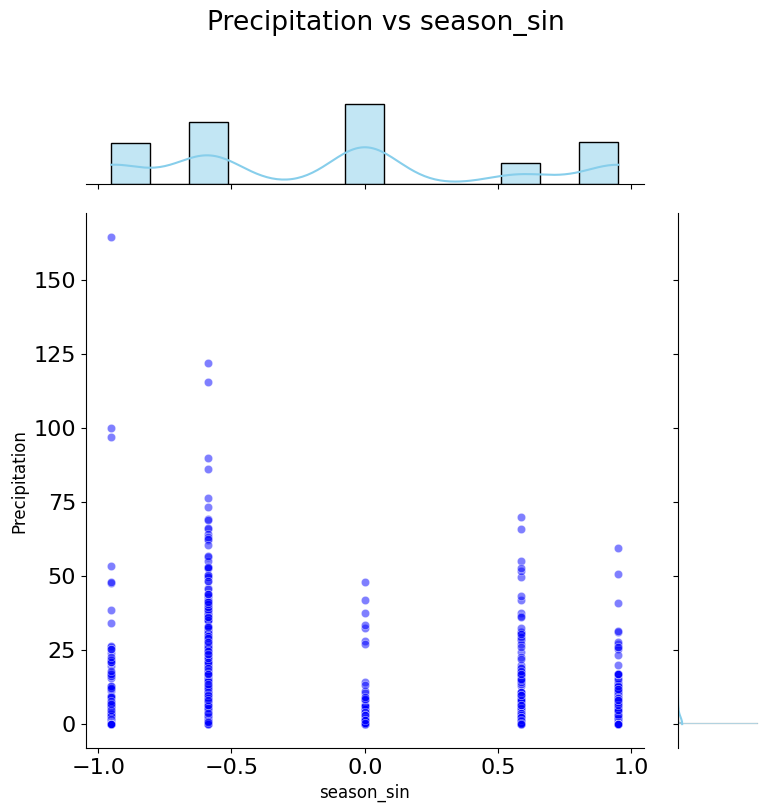

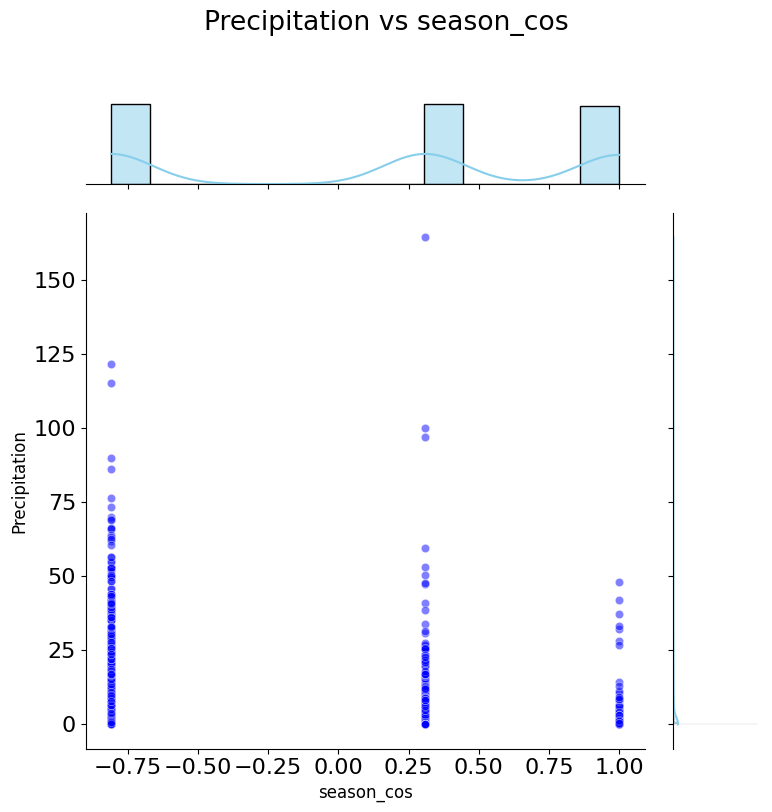

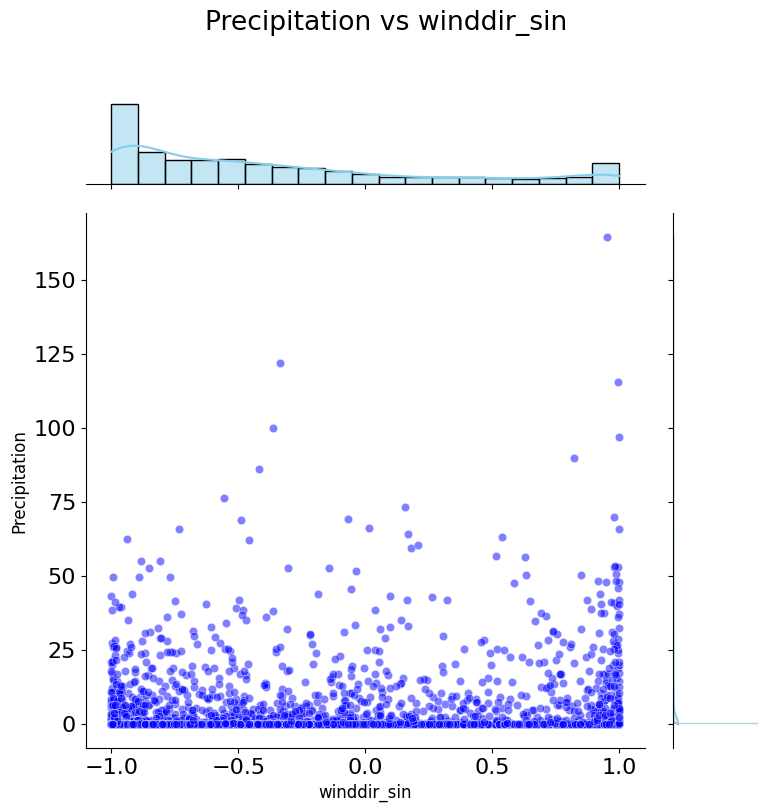

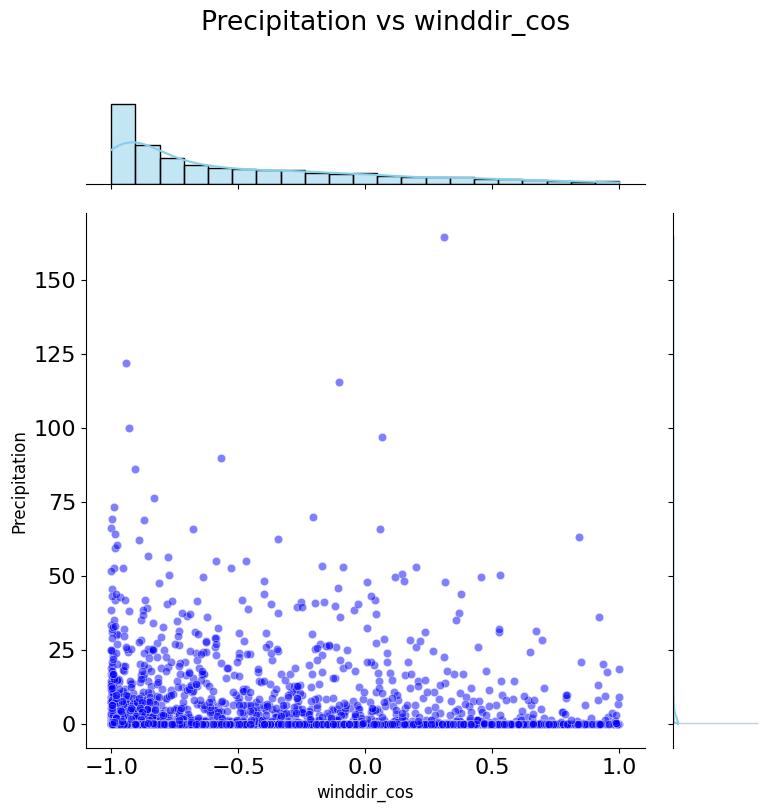

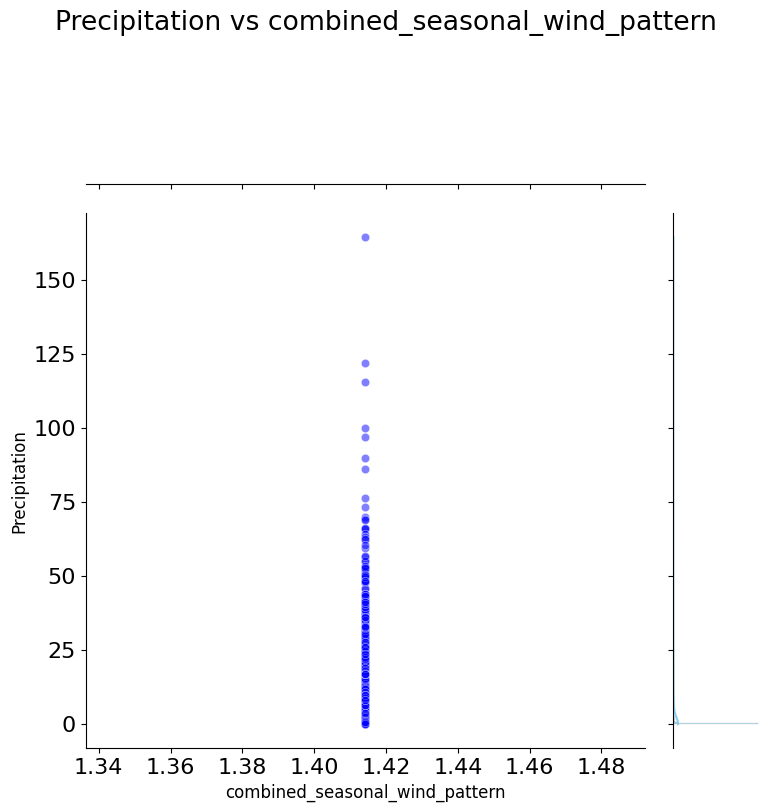

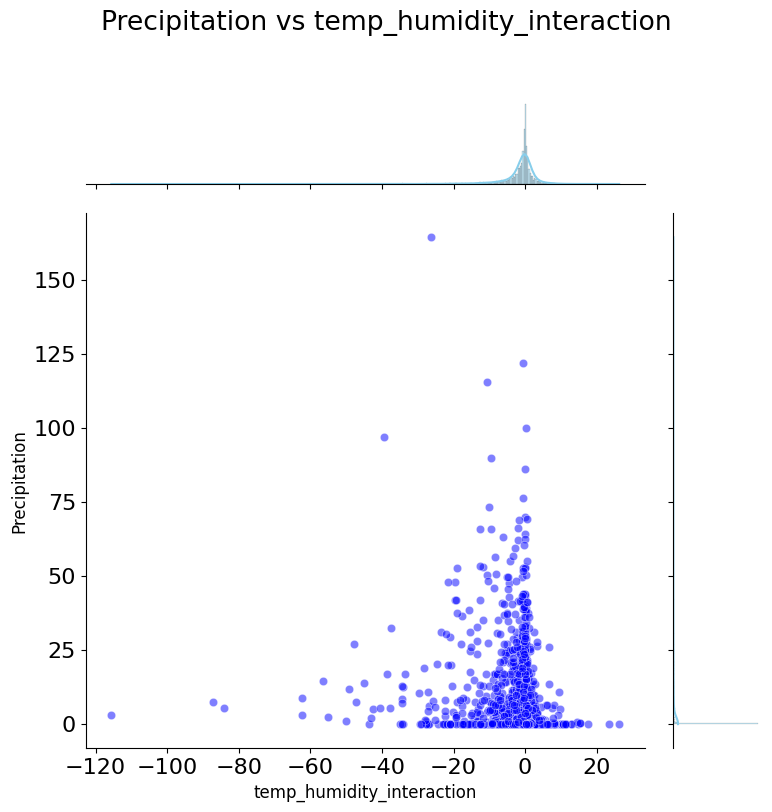

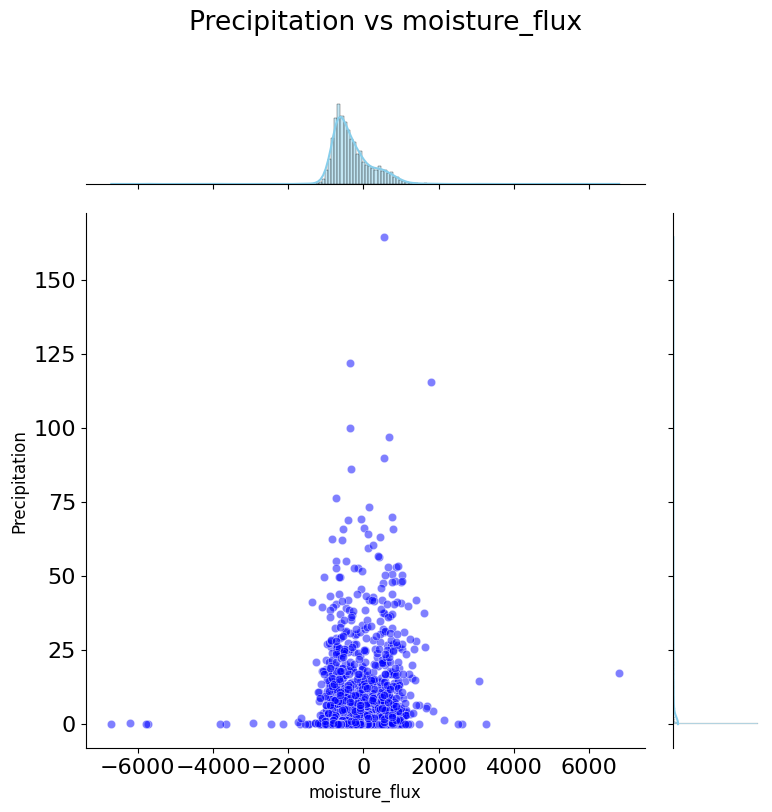

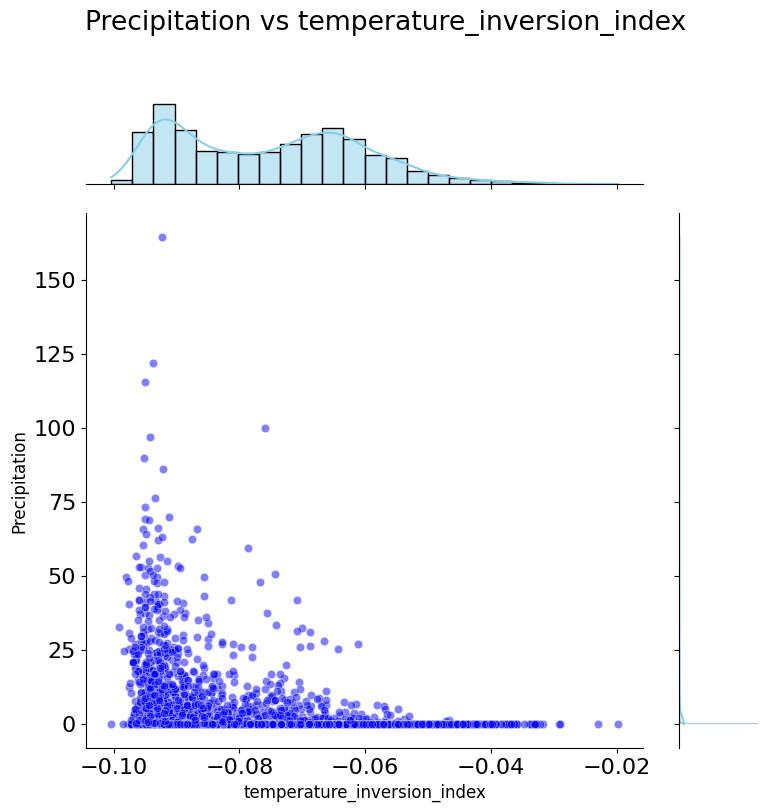

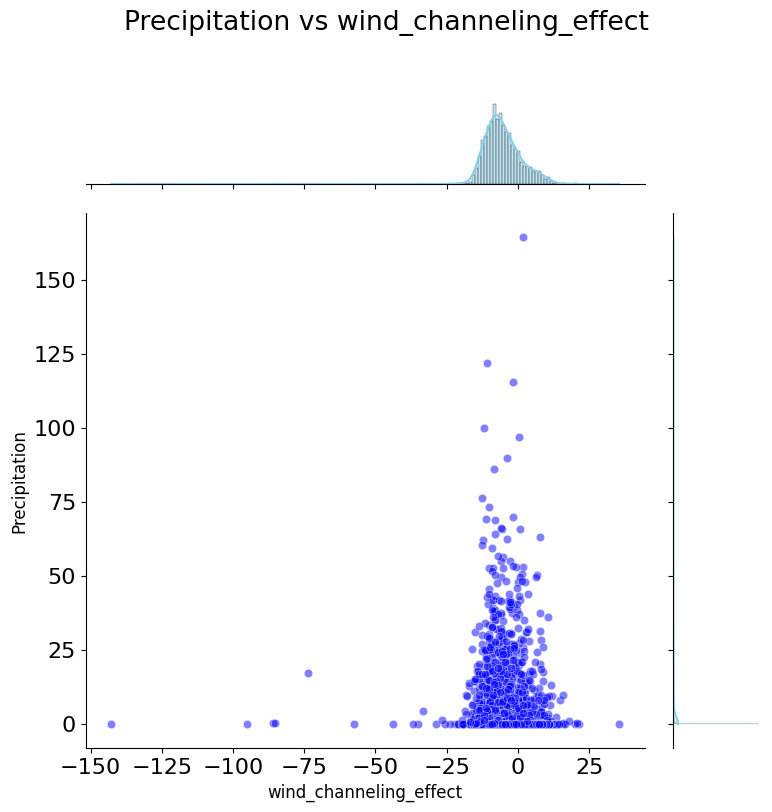

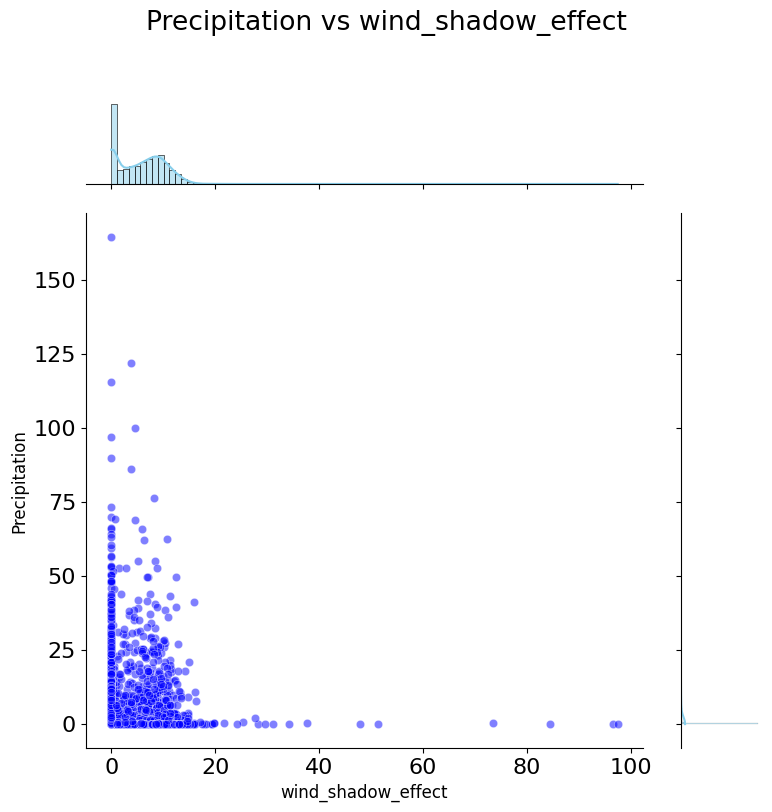

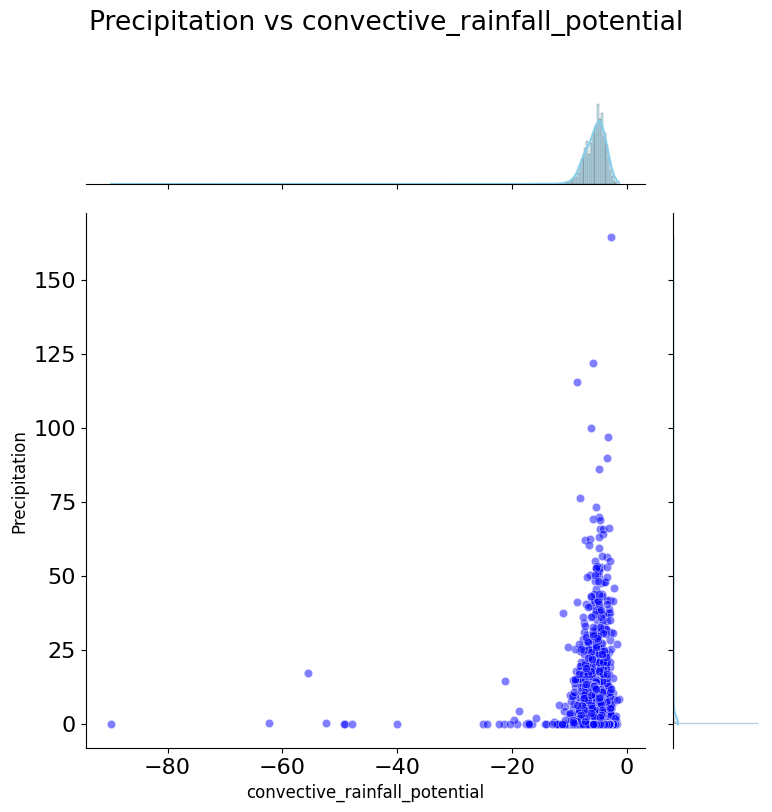

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric features (exclude target if needed)
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'precipitation' in numeric_features:
    numeric_features.remove('precipitation')

# Create joint plots for each numeric feature
for feature in numeric_features:
    g = sns.JointGrid(data=df, x=feature, y='precipitation', height=8)
    g.plot_joint(sns.scatterplot, alpha=0.5, color='blue')  # Scatter plot
    g.plot_marginals(sns.histplot, kde=True, color='skyblue')  # Histograms
    g.set_axis_labels(feature, 'Precipitation', fontsize=12)
    plt.suptitle(f"Precipitation vs {feature}", y=1.02)
    plt.tight_layout()
    plt.show()

In [117]:
# dropping some features based on thier very unusal pattern in the histogram plot
df.drop(columns=['month','season_number','month_sin','month_cos','combined_seasonal_wind_pattern'],inplace=True)

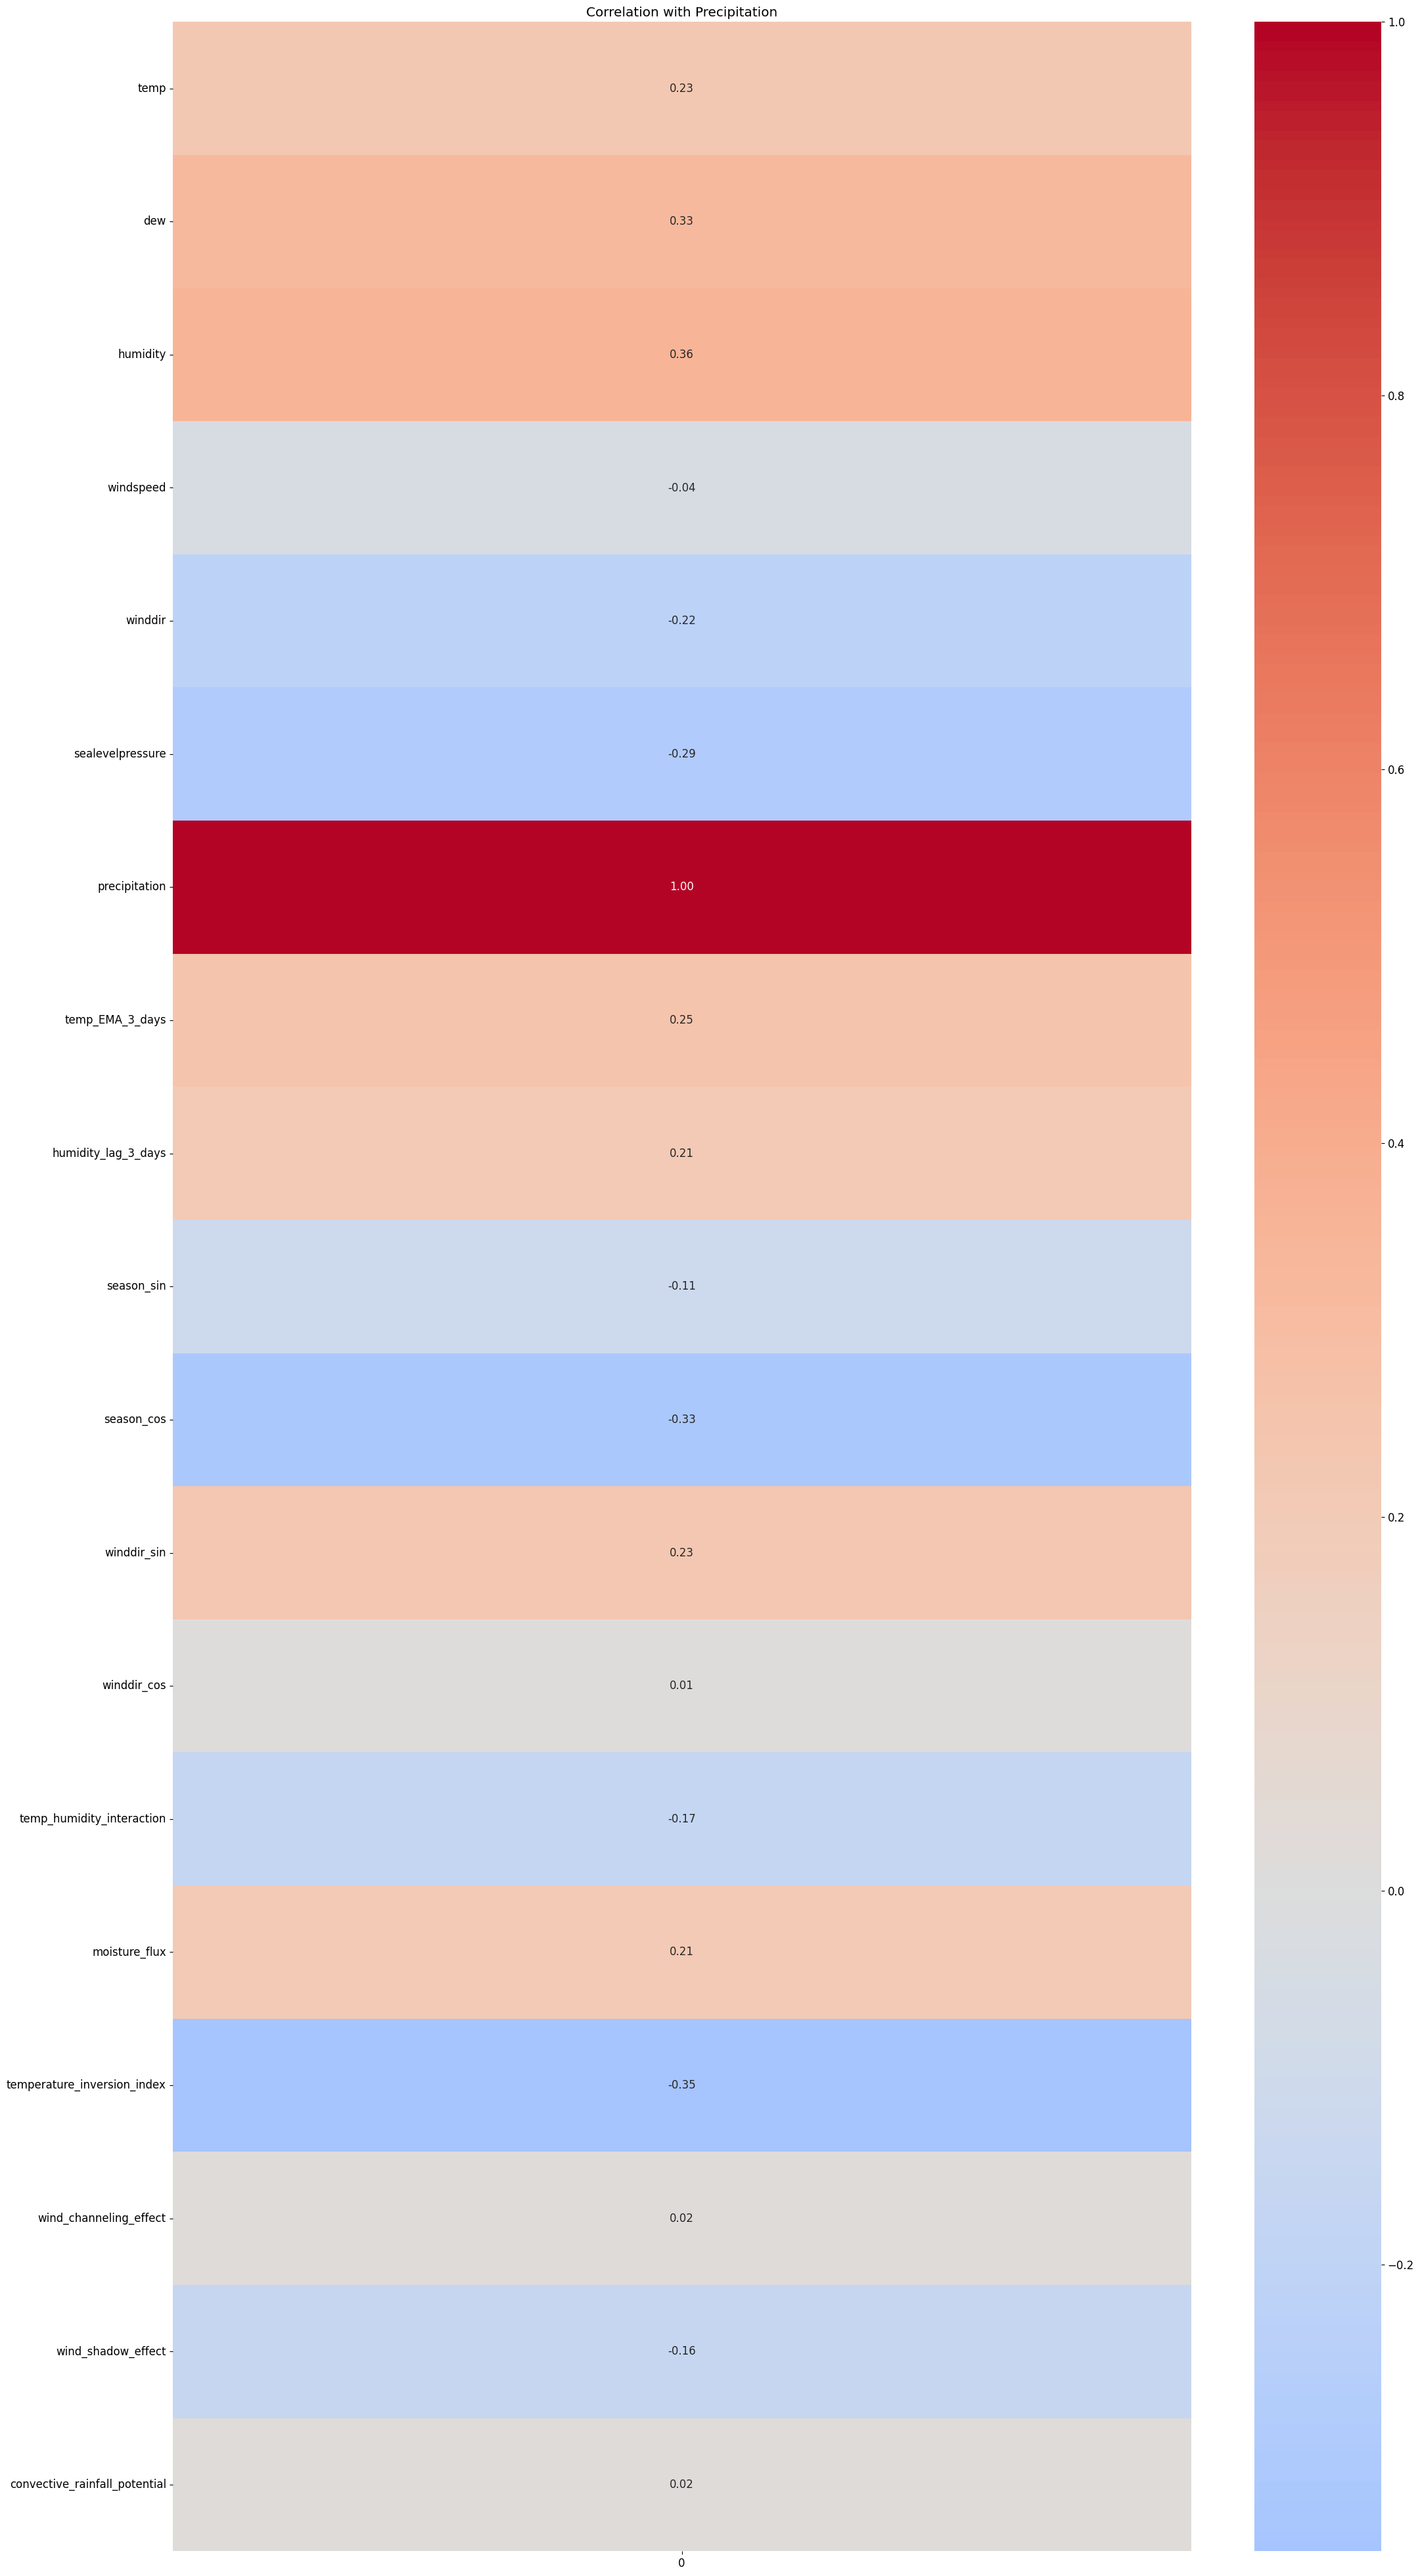

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric features
numeric_df = df.select_dtypes(include=['int64', 'float64'])



# Plot heatmap
plt.rcParams.update({'font.size': 12})



# Compute correlation between 'precipitation' and other columns
precipitation_corr = numeric_df.corrwith(numeric_df["precipitation"])

# Convert to DataFrame for heatmap
precipitation_corr_df = precipitation_corr.to_frame()

# Plot
plt.figure(figsize=(25, 50))
sns.heatmap(precipitation_corr_df, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation with Precipitation")
plt.savefig("/home/momo/Downloads/dataset for prec/cleaned_data/03-interaction_features-visualizations/correlation heatmap/Pearson Correlation Matrix (Numeric Features).png")
plt.show()

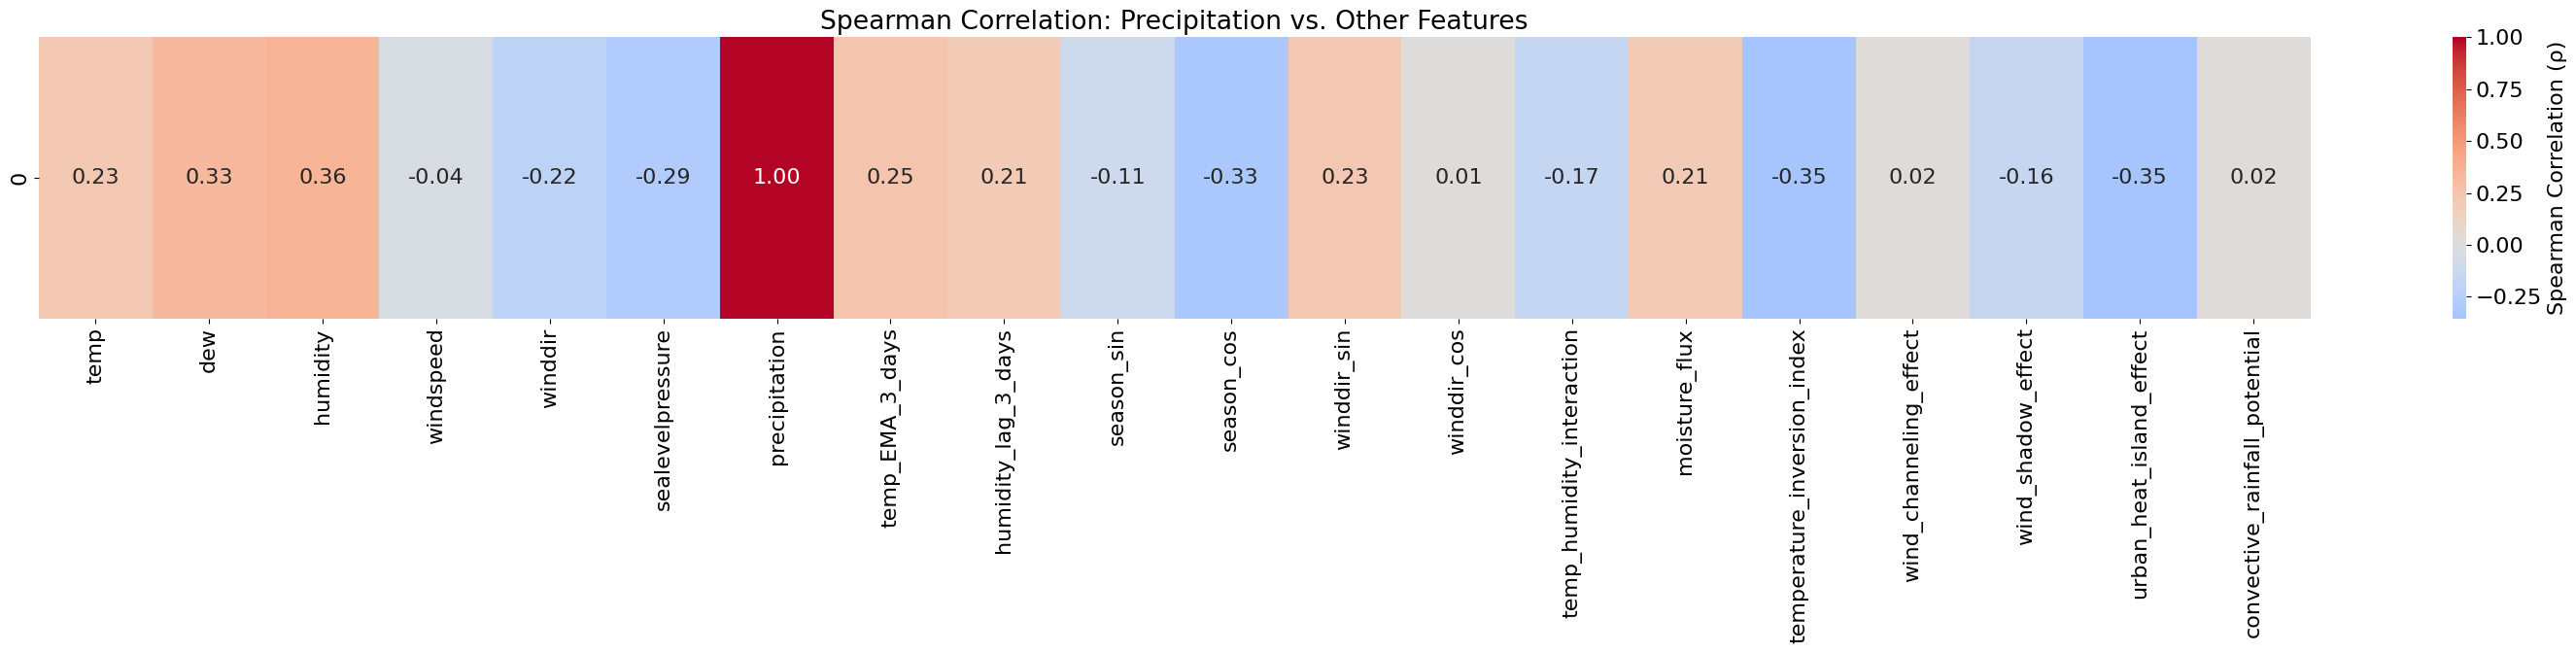

In [66]:
# Reshape correlations for heatmap
precipitation_corr_df = precipitation_corr.to_frame().T  # 1 row × N columns
plt.rcParams.update({'font.size': 16})

# Plot
plt.figure(figsize=(30, 7))  # Wide and short
sns.heatmap(
    precipitation_corr_df, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    center=0,
    cbar_kws={"label": "Spearman Correlation (ρ)"}
)
plt.title("Spearman Correlation: Precipitation vs. Other Features")
plt.tight_layout()
plt.savefig("cleaned_data/03-interaction_features-visualizations/correlation heatmap/correlation heatmapSpearman_Correlation_Heatmap.png")
plt.show()

Correlations for precipitation:
temp                             0.226459
dew                              0.325704
humidity                         0.356992
windspeed                       -0.042588
winddir                         -0.222552
sealevelpressure                -0.292457
precipitation                    1.000000
temp_EMA_3_days                  0.252337
humidity_lag_3_days              0.207724
season_sin                      -0.114301
season_cos                      -0.326381
winddir_sin                      0.233085
winddir_cos                      0.014931
temp_humidity_interaction       -0.165815
moisture_flux                    0.207603
temperature_inversion_index     -0.353311
wind_channeling_effect           0.019949
wind_shadow_effect              -0.159416
convective_rainfall_potential    0.021076
Name: precipitation, dtype: float64


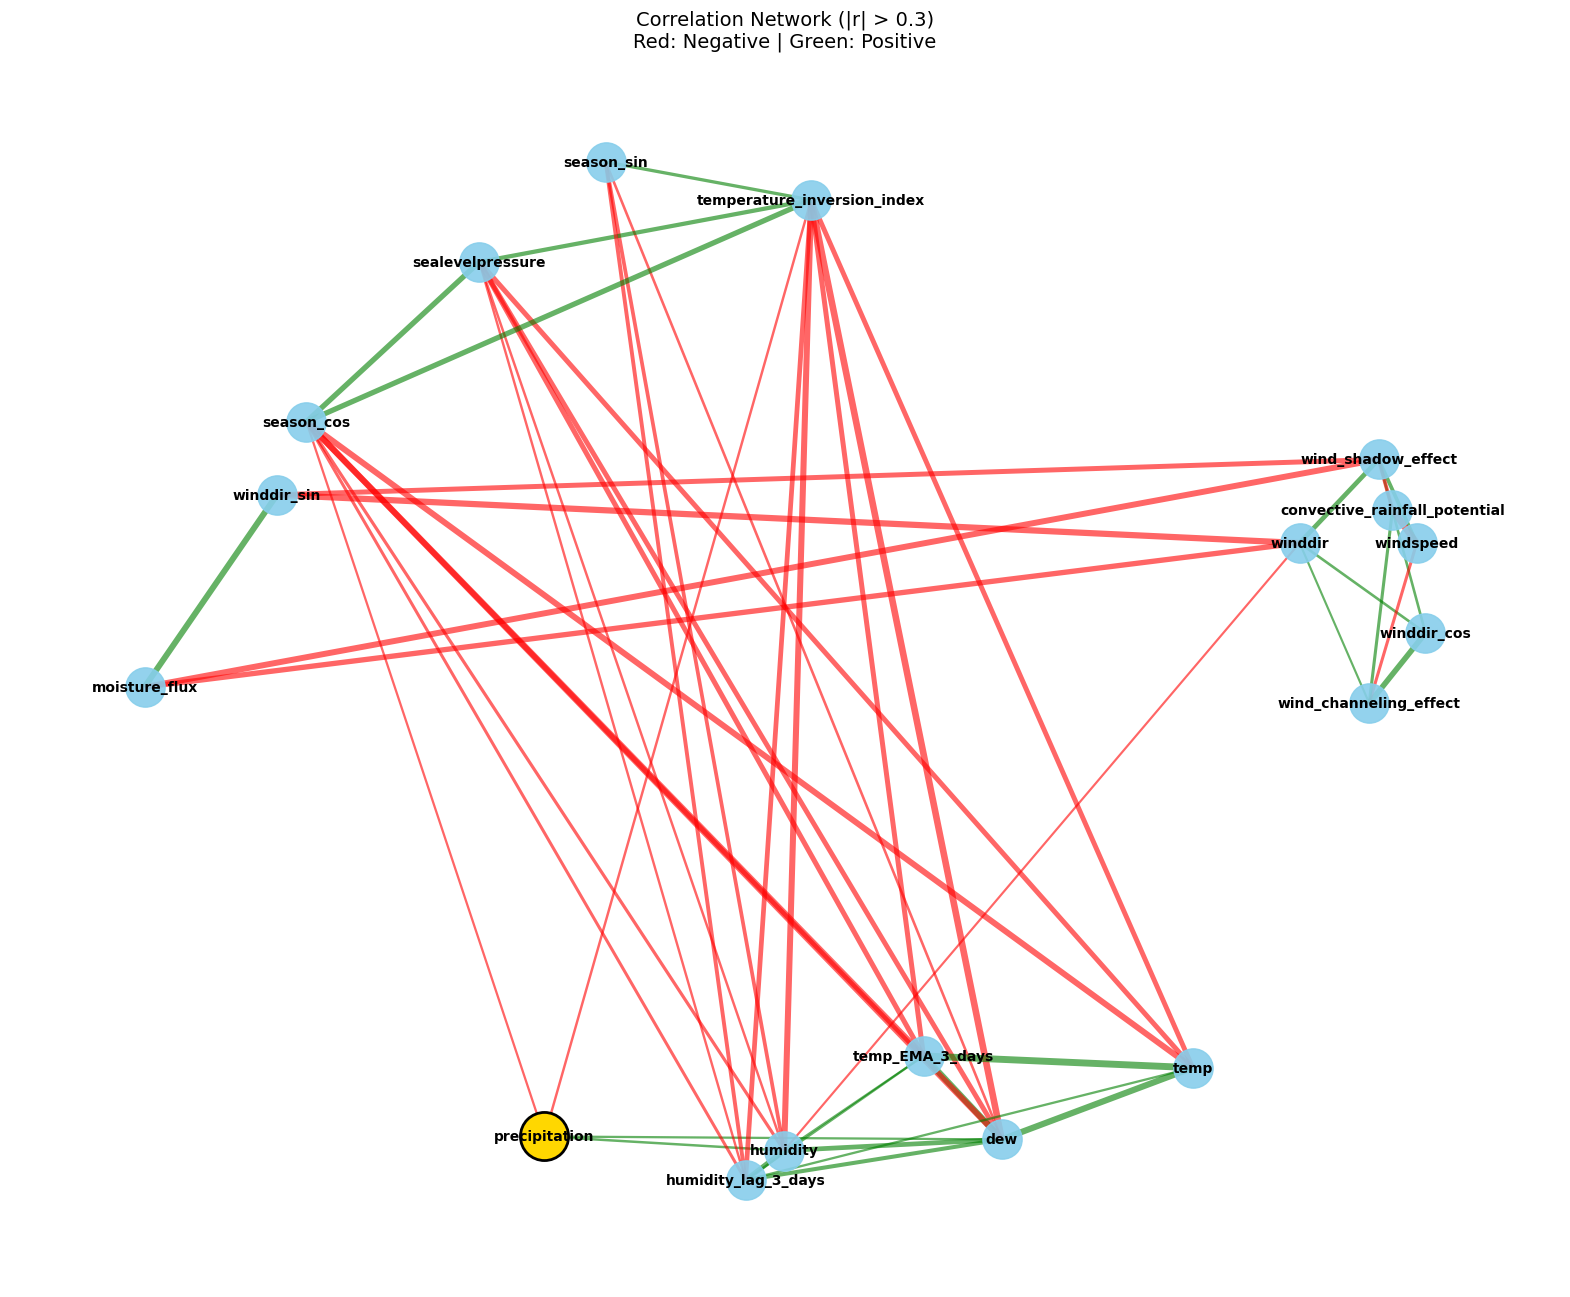

In [119]:
import networkx as nx
import matplotlib.pyplot as plt

# Compute correlation matrix (Pearson/Spearman)
corr_matrix = df.select_dtypes(include=['number']).corr(method='pearson')

# Create graph
G = nx.Graph()
threshold = 0.3 # Adjust based on your needs (strictness)

# Add edges only if correlation exceeds threshold
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            G.add_edge(
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                weight=corr_matrix.iloc[i, j],
                color='red' if corr_matrix.iloc[i, j] < 0 else 'green'
            )

# Draw the graph
plt.figure(figsize=(20, 16))
pos = nx.spring_layout(G, k=0.5)  # k=node spacing parameter

# Extract edge colors/weights
edges = G.edges()
colors = [G[u][v]['color'] for u, v in edges]
weights = [abs(G[u][v]['weight']) * 5 for u, v in edges]  # Scale edge width

# Draw nodes/edges
nx.draw_networkx_nodes(
    G, pos, 
    node_size=800,
    node_color='skyblue',
    alpha=0.9
)
nx.draw_networkx_edges(
    G, pos, 
    edge_color=colors,
    width=weights,
    alpha=0.6
)
nx.draw_networkx_labels(
    G, pos, 
    font_size=10,
    font_weight='bold'
)

# Customize plot
plt.title(
    f"Correlation Network (|r| > {threshold})\n"
    "Red: Negative | Green: Positive",
    fontsize=14
)
plt.axis('off')

# Highlight target variable (if applicable)
target_node = 'precipitation'  # Replace with your target column
if target_node in corr_matrix.columns:  # Check in correlation matrix first
    print(f"Correlations for {target_node}:")
    print(corr_matrix[target_node])
    
    if target_node in G.nodes():
        nx.draw_networkx_nodes(
            G, pos, 
            nodelist=[target_node],
            node_size=1200,
            node_color='gold',
            edgecolors='black',
            linewidths=2
        )
    else:
        print(f"Warning: {target_node} has no correlations above the threshold")
else:
    print(f"Error: {target_node} not found in correlation matrix")
plt.savefig("cleaned_data/03-interaction_features-visualizations/correlation heatmap/correlation_network_graph.png")
plt.show()

In [69]:
# Correlation Network Graph
# Element	Meaning
# Node (Circle)	A feature in your dataset (e.g., age, income, price).
# Edge (Line)	A correlation between two features.
# Edge Color	Red = Negative correlation, Green = Positive correlation.
# Edge Thickness	Thicker = Stronger correlation (absolute value).
# Node Size	Larger = More connections (highly correlated with other features).
# Node Position	Closer nodes = Stronger relationships (via force-directed layout).

In [120]:
# from above 3 correation graph, dropping some low correlated features threshold = 0.2
df = df.drop(columns=["convective_rainfall_potential","wind_shadow_effect","wind_channeling_effect","temp_humidity_interaction","windspeed"])

In [121]:
df = df.drop(columns=["season","winddir"])

In [122]:
df.dtypes

datetime                        object
temp                           float64
dew                            float64
humidity                       float64
sealevelpressure               float64
precipitation                  float64
temp_EMA_3_days                float64
humidity_lag_3_days            float64
season_sin                     float64
season_cos                     float64
winddir_sin                    float64
winddir_cos                    float64
moisture_flux                  float64
temperature_inversion_index    float64
dtype: object

In [123]:
len(df.dtypes)

14

In [124]:
# upon researching 
# moisture_flux and orographic_precipitation_potential are identical (same stats)
# df = df.drop(columns=["orographic_precipitation_potential"]) 
# urban_heat_island_effect may be redundant with temp
# df = df.drop(columns=["urban_heat_island_effect"]) 

# High Correlation Risk : dew_point_depression
# df = df.drop(columns=["dew_point_depression"]) 

In [125]:
df.to_csv("/home/momo/Downloads/dataset for prec/cleaned_data/04-before-traansformation.csv",index=False)

### Apply transformation for linear regression, NN, GRU (future work) , else moving forward mit LightGBM

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew,boxcox,yeojohnson

In [94]:
df = pd.read_csv('/home/momo/Downloads/dataset for prec/cleaned_data/04-before-traansformation.csv')
yeojohnson_df =df.copy(deep=True)

##### applying Box-Cox transformation to skewed features with only positive values and Yeo-Johnson transformation 

In [95]:
numeric_df  =pd.DataFrame(yeojohnson_df.select_dtypes(include=['int', 'float']))
skewness = numeric_df.apply(skew)
print("Skewness of Features:\n", skewness)

Skewness of Features:
 temp                          -0.444997
dew                           -0.160571
humidity                      -0.848851
sealevelpressure              -0.191098
precipitation                  5.129500
temp_EMA_3_days               -0.459797
humidity_lag_3_days           -0.850102
season_sin                     0.330641
season_cos                    -0.263328
winddir_sin                    0.948048
winddir_cos                    1.023757
moisture_flux                  0.017435
temperature_inversion_index    0.339868
dtype: float64


In [96]:
skewed_features = skewness[abs(skewness) > 0.5].index
skewed_features

Index(['humidity', 'precipitation', 'humidity_lag_3_days', 'winddir_sin',
       'winddir_cos'],
      dtype='object')

In [97]:
skewed_df = yeojohnson_df[skewed_features]
skewed_df.drop(columns=['winddir_sin','winddir_cos'],inplace=True)

/tmp/ipykernel_65163/3093735661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skewed_df.drop(columns=['winddir_sin','winddir_cos'],inplace=True)


In [98]:
for i in range(len((skewed_df.columns))):
    try:
        yeojohnson_df[f"{skewed_df.columns[i]}_yeojohnson"],i =(yeojohnson(skewed_df.iloc[:,i]))
    except Exception as e:
        print(e)

In [99]:
yeojohnson_df.dtypes

datetime                           object
temp                              float64
dew                               float64
humidity                          float64
sealevelpressure                  float64
precipitation                     float64
temp_EMA_3_days                   float64
humidity_lag_3_days               float64
season_sin                        float64
season_cos                        float64
winddir_sin                       float64
winddir_cos                       float64
moisture_flux                     float64
temperature_inversion_index       float64
humidity_yeojohnson               float64
precipitation_yeojohnson          float64
humidity_lag_3_days_yeojohnson    float64
dtype: object

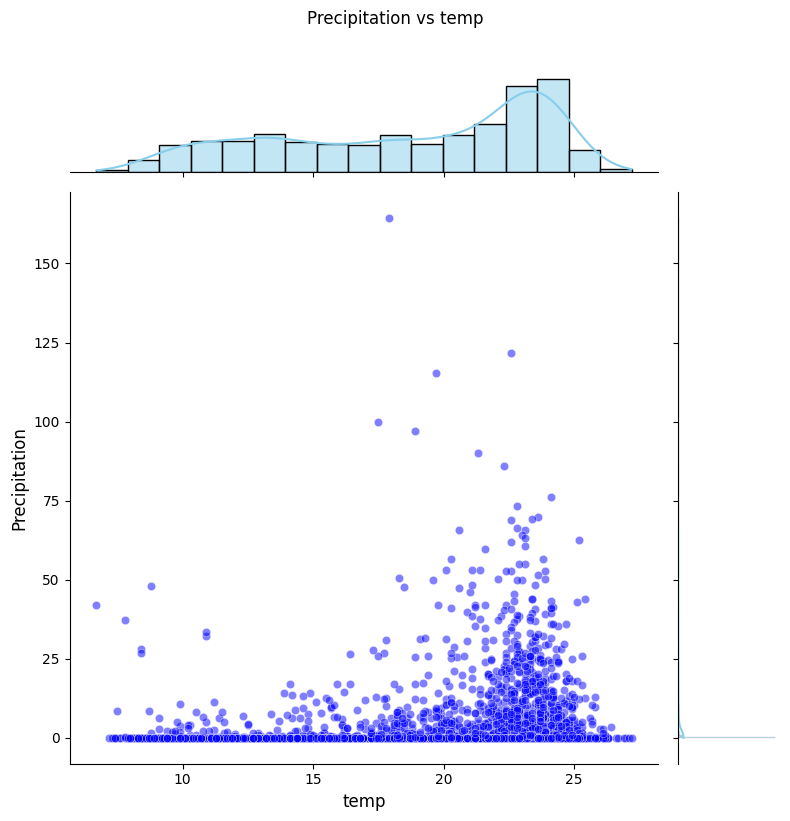

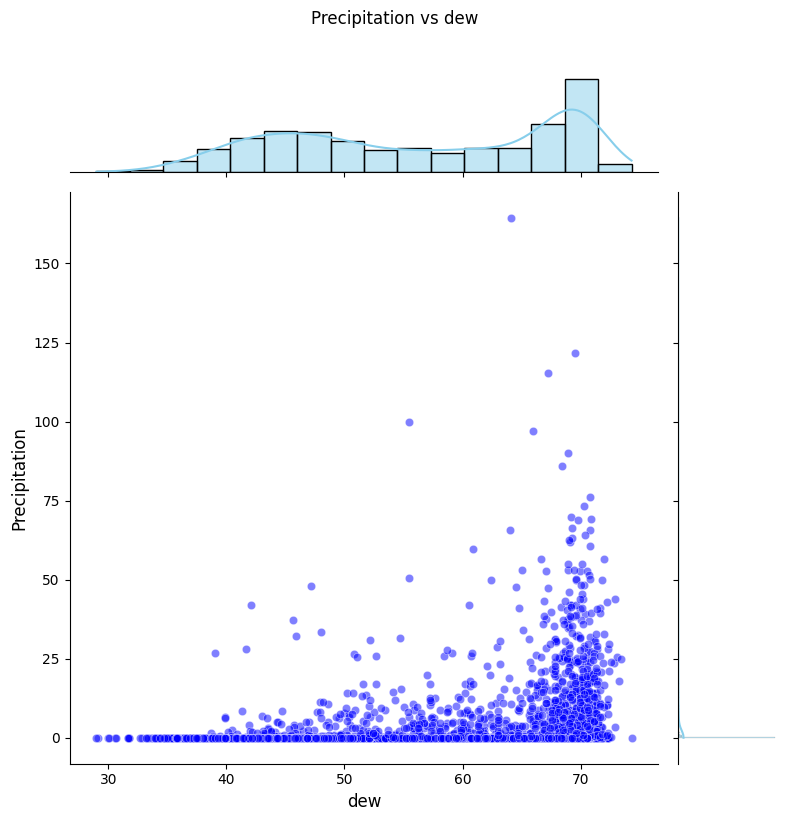

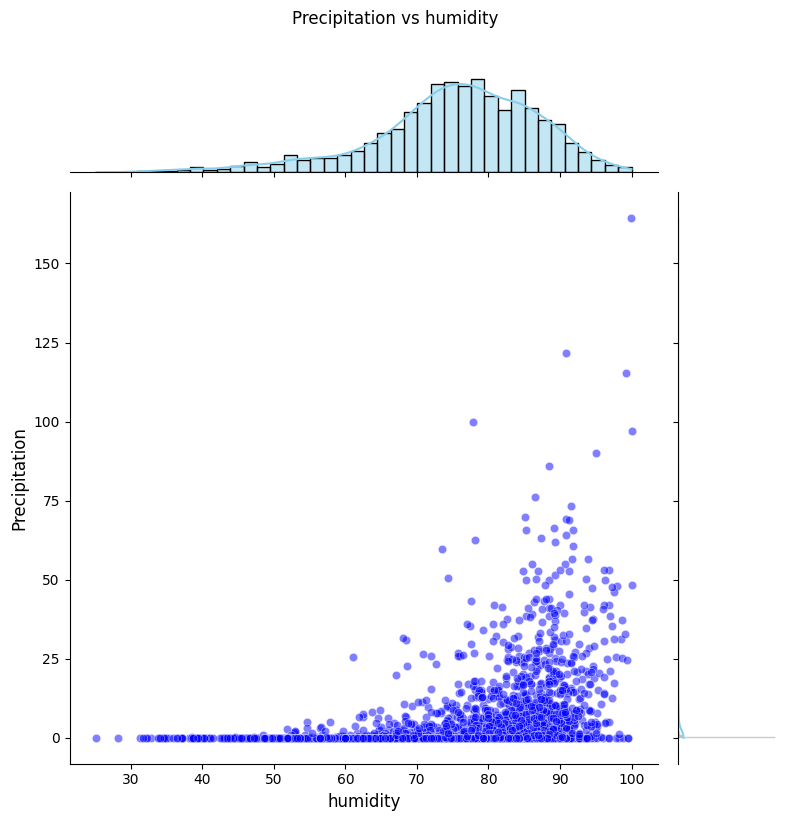

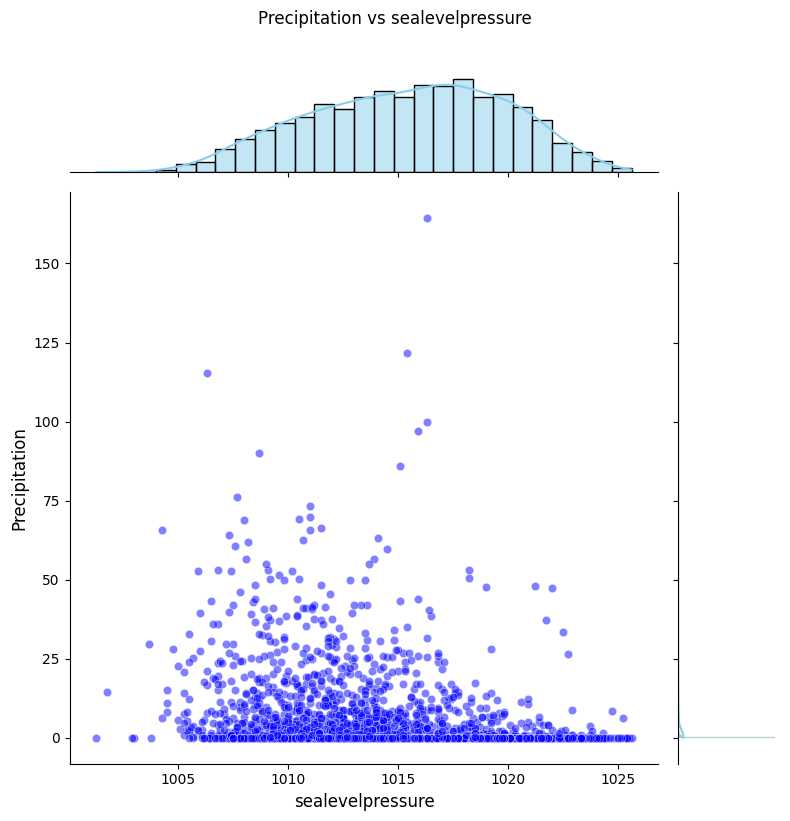

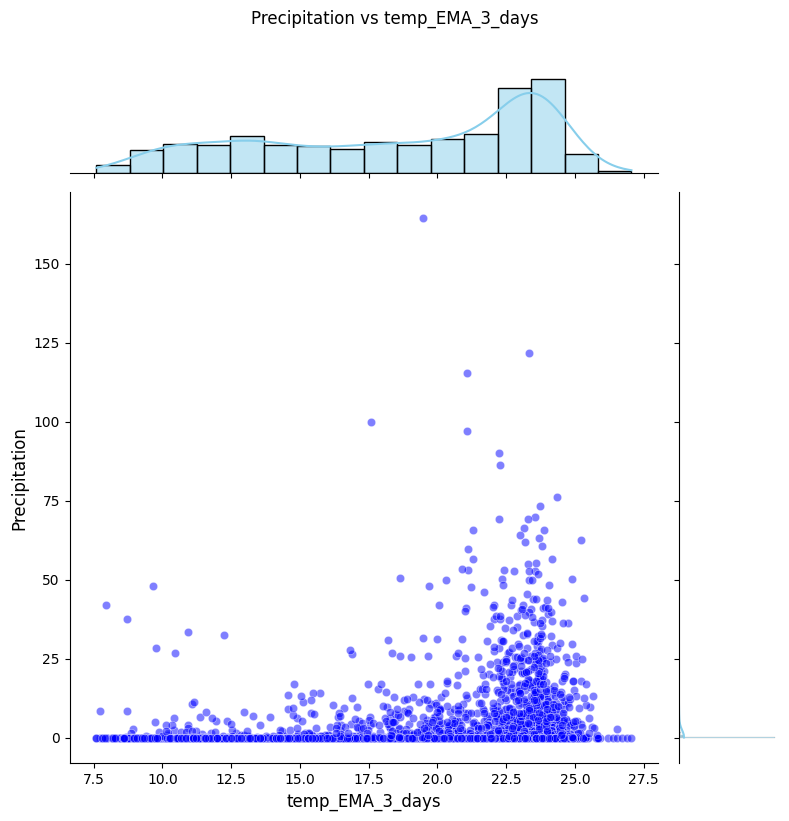

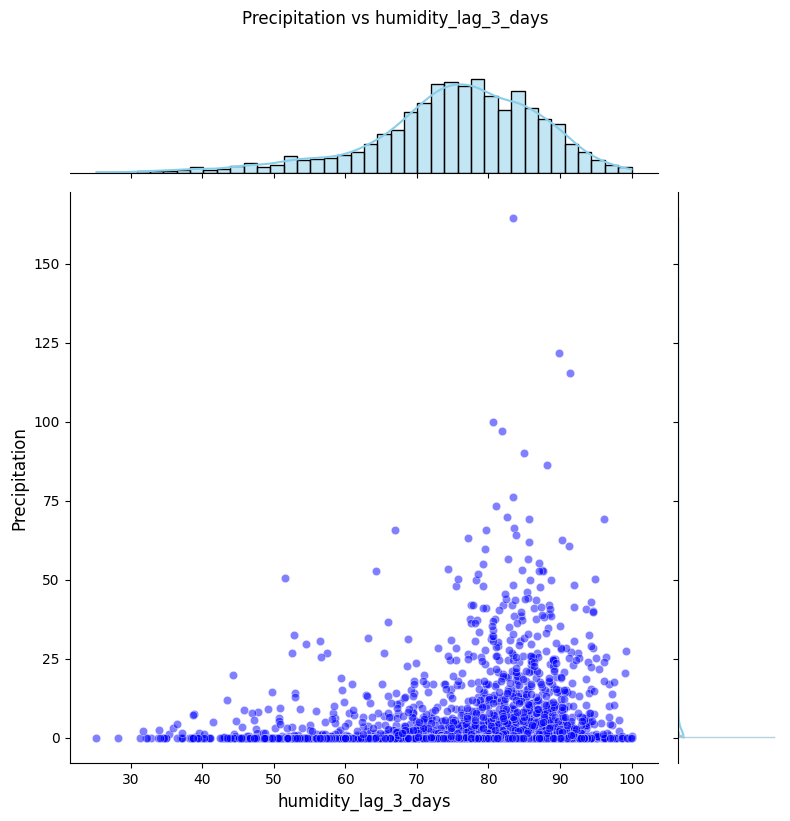

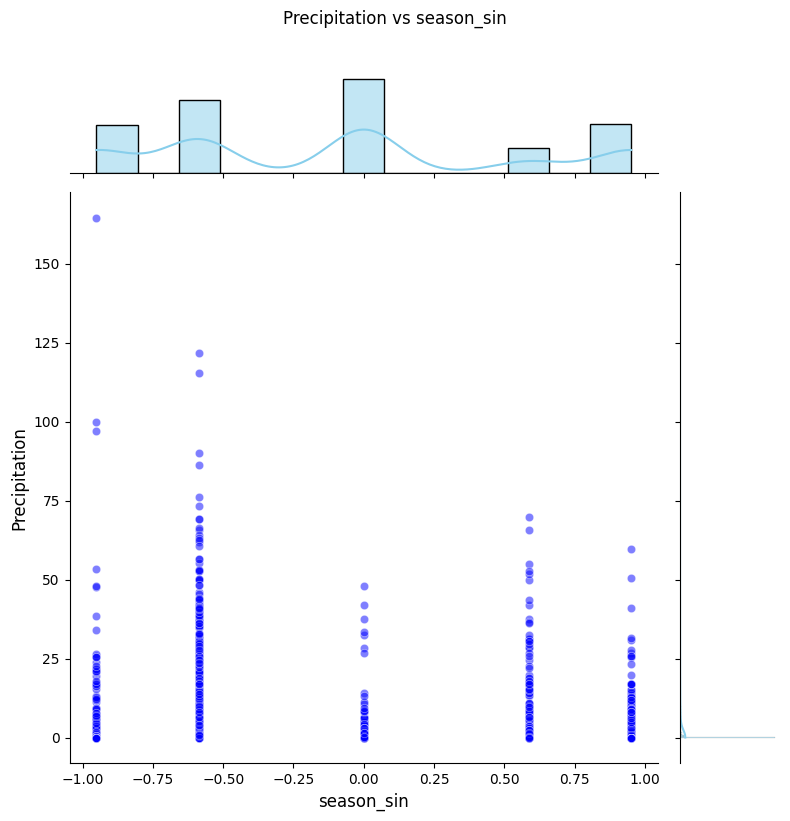

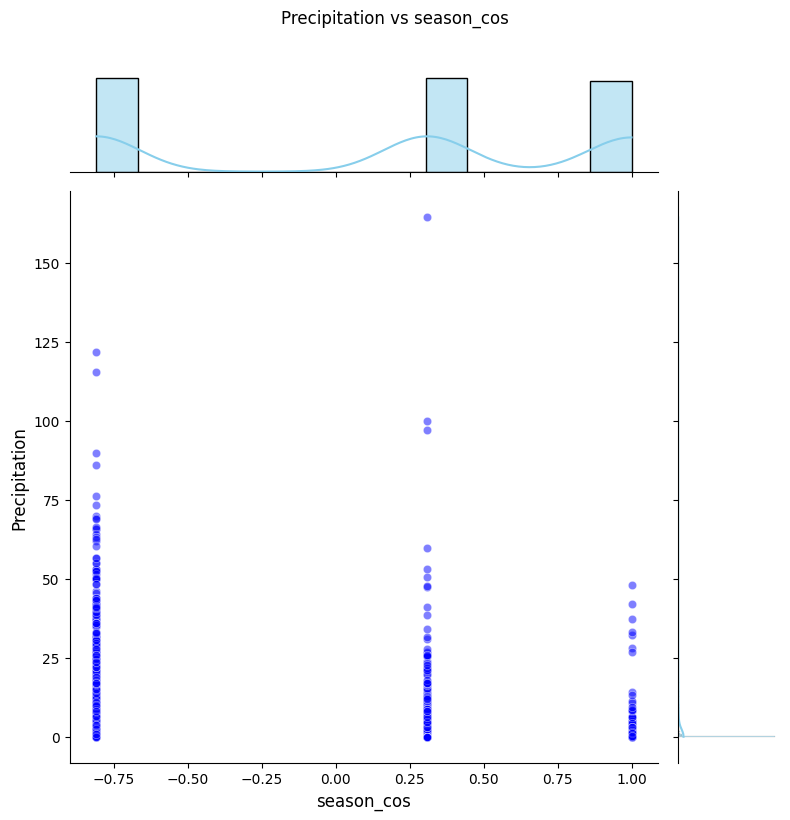

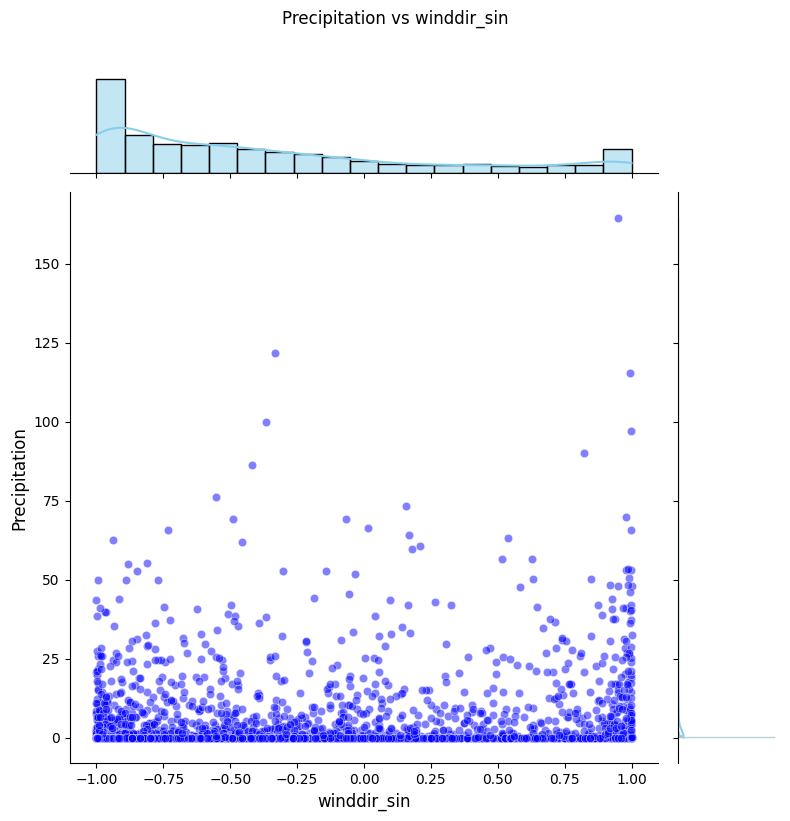

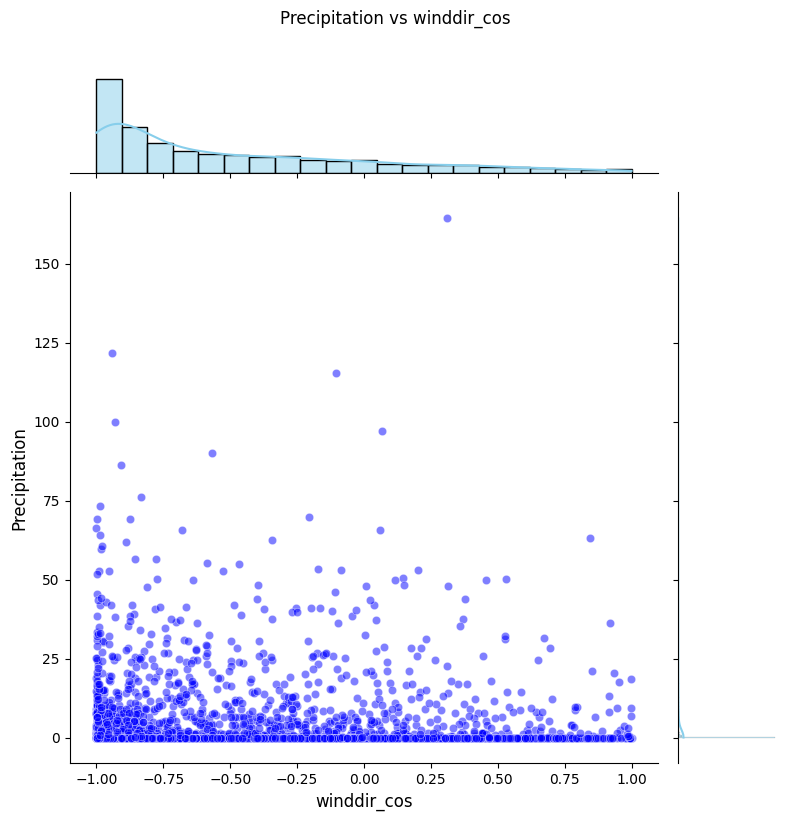

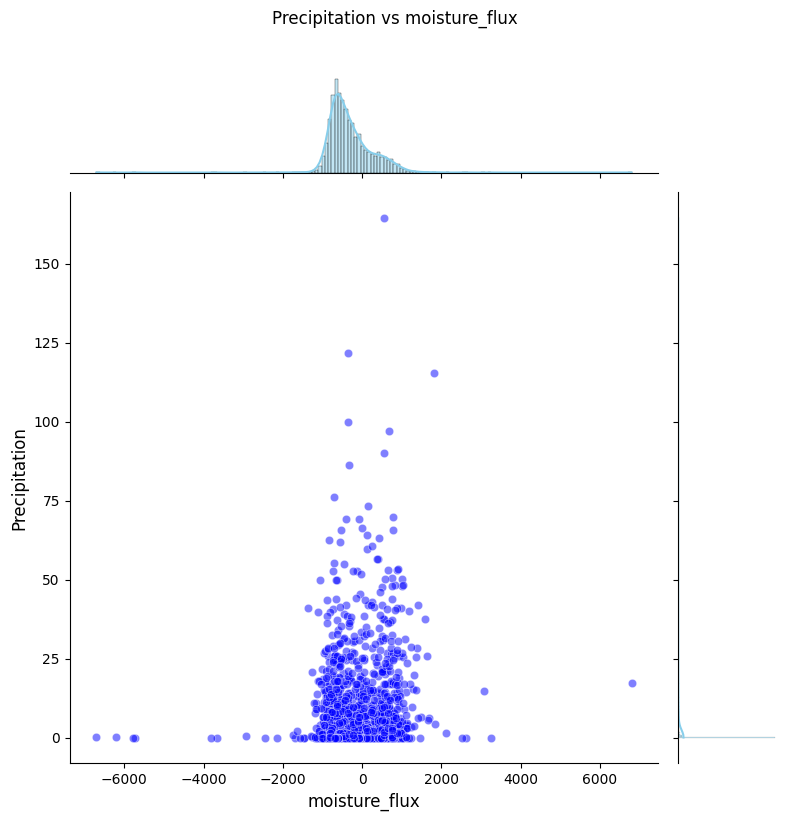

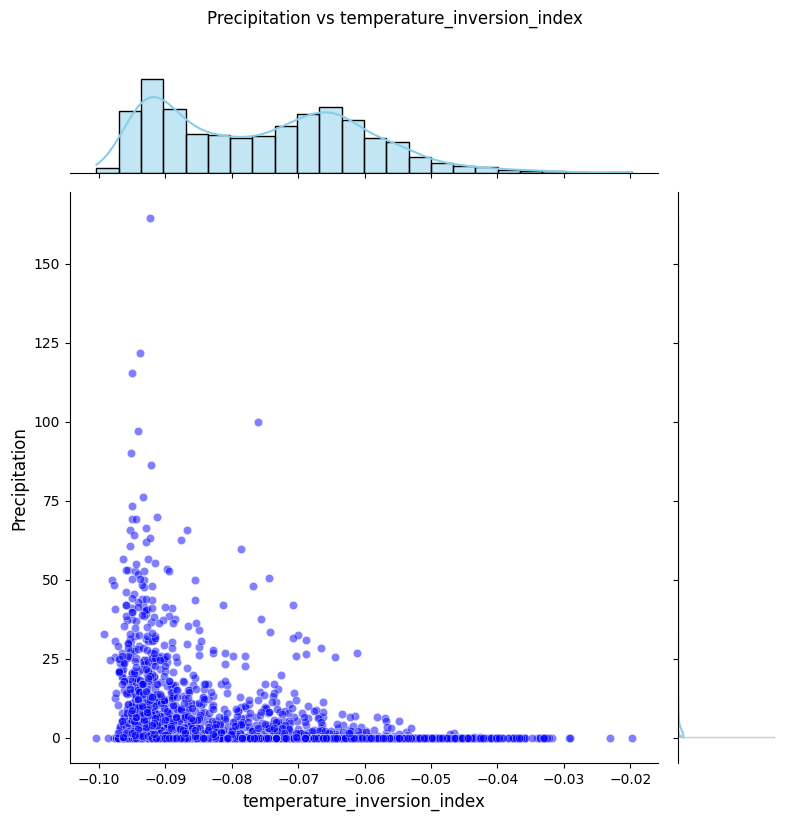

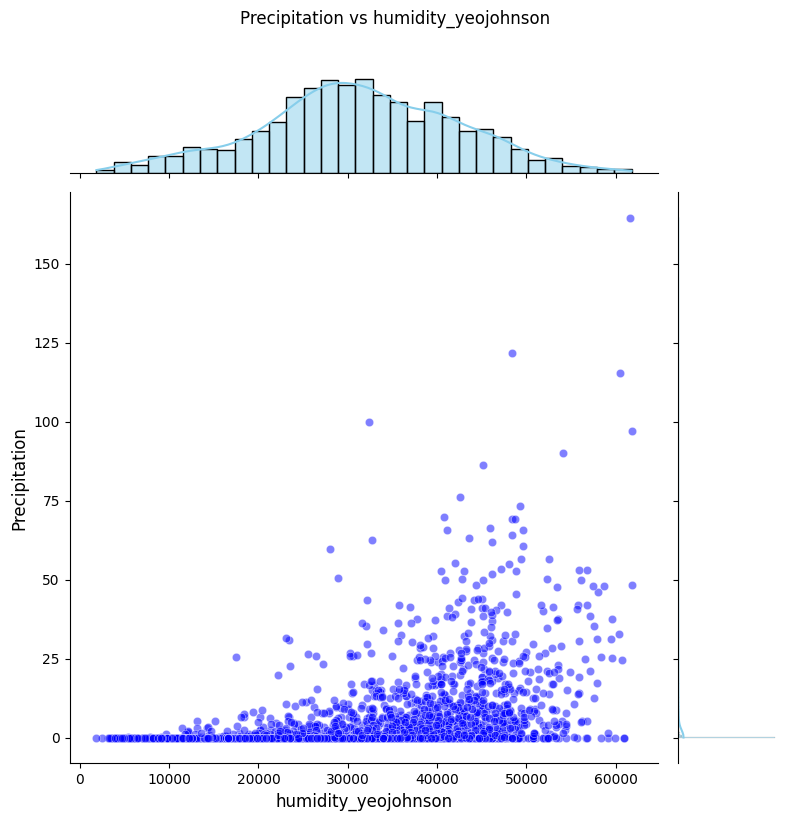

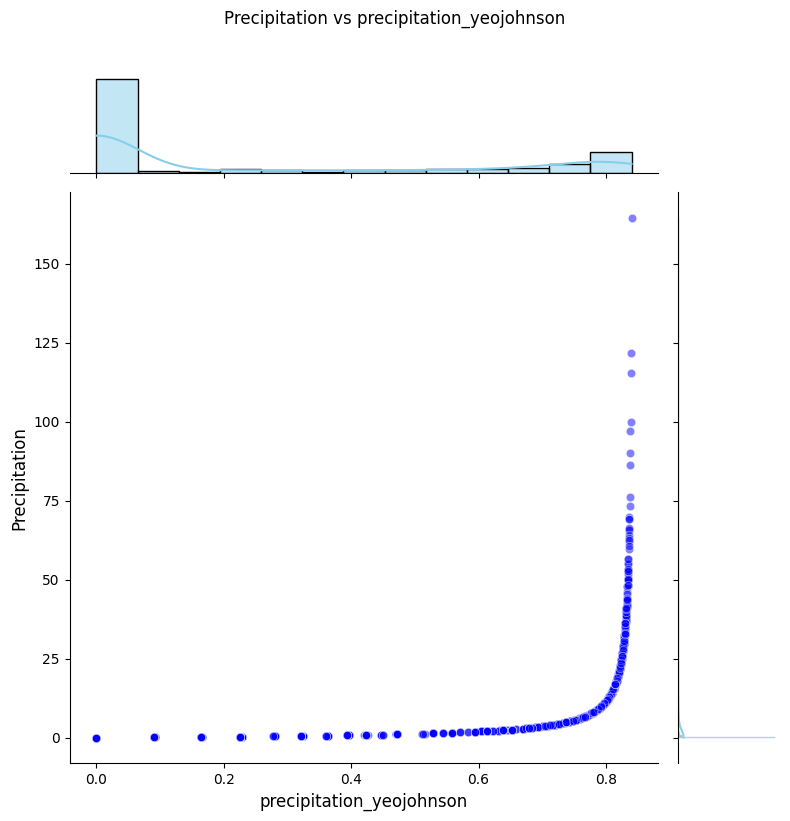

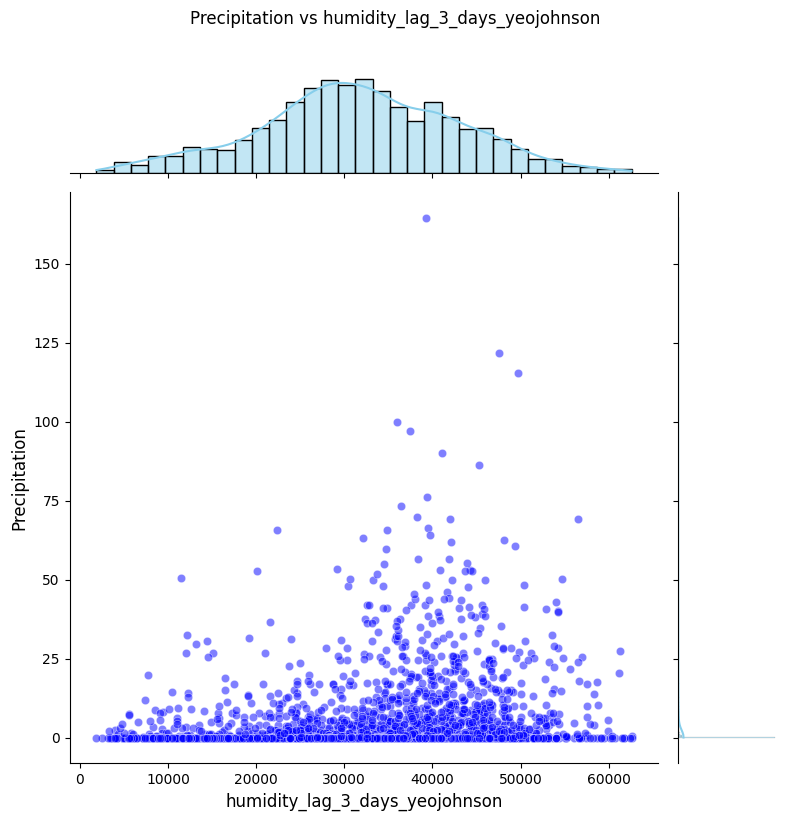

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric features (exclude target if needed)
numeric_features = yeojohnson_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'precipitation' in numeric_features:
    numeric_features.remove('precipitation')

# Create joint plots for each numeric feature
for feature in numeric_features:
    g = sns.JointGrid(data=yeojohnson_df, x=feature, y='precipitation', height=8)
    g.plot_joint(sns.scatterplot, alpha=0.5, color='blue')  # Scatter plot
    g.plot_marginals(sns.histplot, kde=True, color='skyblue')  # Histograms
    g.set_axis_labels(feature, 'Precipitation', fontsize=12)
    plt.suptitle(f"Precipitation vs {feature}", y=1.02)
    plt.tight_layout()
    plt.show()

In [102]:
yeojohnson_df.to_csv("cleaned_data/05-after-yeojohnson-traansformation.csv")

In [108]:
len(df[df.precipitation == 0])

2066